<a href="https://colab.research.google.com/github/NVIDIA/synthda/blob/main/synthda_slowfast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Drive already mounted at /content/MyDrive; to attempt to forcibly remount, call drive.mount("/content/MyDrive", force_remount=True).


# Installation

In [ ]:
!pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio===0.11.0 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install 'iopath'

!pip install pytorchvideo==0.1.5 fvcore==0.1.5.post20221221
!pip install tensorboard
!pip install setuptools==59.5.0
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
ERROR: Could not find a version that satisfies the requirement torch==1.11.0+cu113 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1)
ERROR: No matching distribution found for torch==1.11.0+cu113


# Libraries

In [ ]:
import os
import glob
import cv2
import gc
import json
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.tensorboard import SummaryWriter
import torch
import torchvision
import pytorchvideo
import torchinfo

from pytorchvideo.models.hub import c2d_r50, i3d_r50, slow_r50, slowfast_r50
from pytorchvideo.models.hub import x3d_m
from torchvision.transforms.functional import normalize, crop, hflip
from torchvision.transforms._functional_video import center_crop
#from pytorchvideo.transforms.functional import short_side_scale

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(


In [ ]:
!pip install --upgrade pytorchvideo
#from pytorchvideo.transforms.functional import short_side_scale

In [ ]:
def short_side_scale(video: torch.Tensor, size: int):
    """
    Resize so the shorter spatial side == `size`, keeping aspect ratio.
    video: (T, C, H, W) or (C, T, H, W) tensor
    """
    from torchvision.transforms.functional import resize
    t, c, h, w = video.shape if video.ndim == 4 else (None,)*4
    short, long = (h, w) if h < w else (w, h)
    new_short, new_long = size, int(size * long / short)
    # output: (T,C,H,W)
    return resize(video, [new_short, new_long])

In [ ]:
!pip install --upgrade pip
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install iopath fvcore pytorchvideo tensorboard setuptools torchinfo opencv-python seaborn numpy Pillow scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu124


# Helper Functions

In [ ]:
# function to create directories
def create_dir(target_dir):
    if not os.path.exists(target_dir):
        try:
            os.makedirs(target_dir)
        except:
            pass

In [ ]:
def write_action(action_filepath,action_name,action_id,action_type,tabsize=2):
    action_name_str = '\tname: "{}"'.format(action_name)
    action_id_str = '\tlabel_id: {}'.format(action_id)
    action_type_str = '\tlabel_type: {}'.format(action_type)

    with open(action_filepath, 'a') as action_file:
        action_file.write('label {\n')
        action_file.write(action_name_str.expandtabs(tabsize))
        action_file.write('\n')
        action_file.write(action_id_str.expandtabs(tabsize))
        action_file.write('\n')
        action_file.write(action_type_str.expandtabs(tabsize))
        action_file.write('\n')
        action_file.write('}\n')

In [ ]:
# function to get videoinfo
def get_videoinfo(videofile):

    stream = cv2.VideoCapture(videofile)
    assert stream.isOpened(), 'Cannot capture source'

    datalen = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = stream.get(cv2.CAP_PROP_FPS)
    frameSize = (int(stream.get(cv2.CAP_PROP_FRAME_WIDTH)), int(stream.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    fourcc = int(stream.get(cv2.CAP_PROP_FOURCC))
    videoinfo = {'no_images': datalen, 'fps': fps, 'frameSize': frameSize, 'fourcc': decode_fourcc(fourcc)}

    stream.release()

    return videoinfo

# function to decode fourcc
def decode_fourcc(cc):
    return "".join([chr((int(cc) >> 8 * i) & 0xFF) for i in range(4)])

In [ ]:
# function to split df into train and test sets
def split(split_data,split_target,split_size,split_label_1,split_label_2):

    # get the locations
    X = split_data.drop(columns=[split_target])
    y = split_data[split_target]

    # split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=297,stratify=y)

    # determine fold
    X_train[split_target] = y_train
    X_train['fold'] = split_label_1

    X_test[split_target] = y_test
    X_test['fold'] = split_label_2

    # concat
    split_df = pd.concat([X_train,X_test])

    return split_df, X_train, X_test

In [ ]:
# convert video into images
def vid_to_img(videofile,img_dest_dir):

  # create img_dest_dir
  os.makedirs(img_dest_dir,exist_ok=True)

  # read video and save images
  img_paths = []
  stream = cv2.VideoCapture(videofile)
  assert stream.isOpened(), 'Cannot capture source'

  datalen = int(stream.get(cv2.CAP_PROP_FRAME_COUNT))

  for i in tqdm(range(datalen),total=datalen):
    (grabbed, frame) = stream.read()
    img_path = os.path.join(img_dest_dir,'{}.jpg'.format(i))
    cv2.imwrite(img_path,frame)
    img_paths.append(img_path)

  stream.release()

  return img_paths

In [ ]:
def create_frames_dir(in_df_video_info,in_frames_dir):

    out_df_frame_info = pd.DataFrame(columns=['vid_id','frame_id','training_frame_path'])

    # obtain video_ids
    video_ids = list(in_df_video_info['vid_id'])

    # copy images into frames_dir
    for i, video_id in enumerate(video_ids):
        df_video = in_df_video_info.loc[in_df_video_info['vid_id']==video_id]

        if df_video.empty:
            print(f"Warning: No video found with vid_id {video_id}. Skipping...")
            continue

        assert len(df_video) == 1

        print('Extracting images for video {} of {}'.format(i+1,len(video_ids)))
        img_dest_dir = os.path.join(in_frames_dir,str(video_id))
        os.makedirs(img_dest_dir,exist_ok=True)

        # obtain video_images
        image_paths = vid_to_img(df_video['video_path'].iloc[0],img_dest_dir)

        for image_path in image_paths:

            # rename image
            image_name = os.path.basename(image_path)
            frame_id = int(image_name.split('.')[0])

            # store info
            df_dict = pd.DataFrame.from_dict({'vid_id':[video_id],
                                              'frame_id':[frame_id],
                                              'training_frame_path':[image_path]})
            out_df_frame_info = pd.concat([out_df_frame_info,df_dict],ignore_index=True)

    return out_df_frame_info

In [ ]:
def create_frame_lists_csv(in_df):

    out_df = pd.DataFrame(columns=['vid_id','frame_id','rel_path'])

    for i, row_i in tqdm(in_df.iterrows(),total=len(in_df)):

        # obtain video info
        vid_id = row_i['vid_id']
        video_path = row_i['video_path']

        # obtain images
        dst_folder = os.path.join(FRAMES_DIR,str(vid_id))
        video_images = sorted(glob.glob(str(os.path.join(dst_folder,'*.jpg'))))

        for image in video_images:
            image_name = os.path.basename(image)
            frame_id = int(image_name.split('.')[0])
            rel_path = str(os.path.join(str(vid_id),image_name))

            # store info
            df_dict = pd.DataFrame.from_dict({'vid_id':[vid_id],
                                              'frame_id':[frame_id],
                                              'rel_path':[rel_path]})
            out_df = pd.concat([out_df,df_dict],ignore_index=True)

    return out_df

In [ ]:
def create_annotations_csv(in_df):

    out_df = pd.DataFrame(columns=['vid_id', 'frame_id',
                                   'frame_timestamp',
                                   'action_label'])

    for i, row_i in tqdm(in_df.iterrows(),total=len(in_df)):

        # obtain necessary video info
        vid_id = row_i['vid_id']
        action_id = row_i['action_id']
        video_fps = row_i['fps']

        # obtain images
        dst_folder = os.path.join(FRAMES_DIR,str(vid_id))
        video_images = sorted(glob.glob(str(os.path.join(dst_folder,'*.jpg'))))

        for image in video_images:

            # obtain variables
            image_name = os.path.basename(image)
            frame_id = int(image_name.split('.')[0].split('_')[-1])
            frame_timestamp = frame_id / video_fps

            # store
            df_dict = pd.DataFrame.from_dict({'vid_id':[vid_id],
                                              'frame_id':[frame_id],
                                              'frame_timestamp':[frame_timestamp],
                                              'action_label':[action_id]})

            out_df = pd.concat([out_df,df_dict],ignore_index=True)

    return out_df

In [ ]:
def clip_sampler_random(in_last_clip_end_time,in_is_last_clip,in_frame_ids):
    """
    Randomly samples clip of size CLIP_DURATION (in terms of number of frames) from video frames.
    Args:
        in_last_clip_end_time (int): the last frame id of last clip that was sampled
        in_is_last_clip (int): current clip count for random sampling
        in_frame_ids (list): list of all frame_ids for video
    Returns:
        out_clip_start_frame (int): starting frame id of the sampled clip
        out_clip_end_frame (int): ending frame id of the sampled clip
        out_is_last_clip: indicator to control when clip sampling ends
    """

    max_possible_clip_start = max(len(in_frame_ids) - CLIP_DURATION, 0)

    out_clip_start = random.randint(0, max_possible_clip_start)
    out_clip_end = out_clip_start + CLIP_DURATION

    if in_is_last_clip == None:
        out_is_last_clip = 1
    elif isinstance(in_is_last_clip, int) and in_is_last_clip <= 3:
        out_is_last_clip = in_is_last_clip + 1
    else:
        out_is_last_clip = 'Yes'

    return out_clip_start, out_clip_end, out_is_last_clip

def clip_sampler_uniform(in_last_clip_end_time,in_is_last_clip,in_frame_ids):

    if in_is_last_clip==None:
        out_clip_start = 0
        out_clip_end = CLIP_DURATION
    else:
        out_clip_start = in_last_clip_end_time
        out_clip_end = out_clip_start + CLIP_DURATION

    if out_clip_end + CLIP_DURATION >= len(in_frame_ids):
        out_is_last_clip = 'Yes'
    else:
        out_is_last_clip = 'No'

    return out_clip_start, out_clip_end, out_is_last_clip

In [ ]:
def RandomShortSideScale(in_video_frames,in_min_size,in_max_size):
    size = torch.randint(in_min_size, in_max_size + 1, (1,)).item()
    return short_side_scale(in_video_frames, size)

In [ ]:
def read_label_map(in_label_map_file):
    """
    Read label map and class ids.
    Args:
    in_label_map_file (str): Path to a .pbtxt containing class id's and class names
    Returns:
    out_label_map (dict): A dictionary mapping class id to the associated class names.
    out_class_ids (set): A set of integer unique class id's
    """
    out_label_map = {}
    out_class_ids = set()
    name = ""
    class_id = ""
    with open(in_label_map_file, "r") as f:
        for line in f:
            if line.startswith("  name:"):
                name = line.split('"')[1]
            elif line.startswith("  id:") or line.startswith("  label_id:"):
                class_id = int(line.strip().split(" ")[-1])
                out_label_map[class_id] = name
                out_class_ids.add(class_id)
    return out_label_map, out_class_ids

def load_image_lists(in_frame_paths_file, in_video_path_prefix):
    """
    Loading image paths from the corresponding file.
    Args:
    in_frame_paths_file (str): Path to a file containing relative paths
        to all the frames in the video. Each line in the file is of the
        form <video_name frame_id rel_path>
    in_video_path_prefix (str): Path to be augumented to the each relative
        frame path to get the global frame path
    Returns:
    out_image_paths_list: A dictionary of list containing absolute frame paths.
        Wherein the outer dictionary is per video and inner dictionary is per frame id.
    """

    out_image_paths = {}

    with open(in_frame_paths_file, "r") as f:
        for line in f:
            row = line.split()
            assert len(row) == 3

            # obtain vid_id
            vid_id = row[0]

            # add info to dictionary
            if vid_id not in out_image_paths:
                out_image_paths[vid_id] = {}

            # obtain frame_id and absolute frame paths
            frame_id = int(row[1])
            frame_path = os.path.join(in_video_path_prefix, row[2])

            # store absolute frame paths
            out_image_paths[vid_id][frame_id] = frame_path

    # sort frame_paths by frame_id
    out_image_paths_list = {}
    for vid_id in out_image_paths:
        out_image_paths_list[vid_id] = {}
        sorted_frame_ids = sorted(out_image_paths[vid_id])
        for frame_id in sorted_frame_ids:
            out_image_paths_list[vid_id][frame_id] = out_image_paths[vid_id][frame_id]

    return out_image_paths_list

def load_and_parse_labels_csv(in_frame_labels_file,in_allowed_class_ids=None):
    """
    Parses Kinetics per frame labels .csv file.
    Args:
    in_frame_labels_file (str): Path to the file containing labels per key frame. The file format is given by
        <video_name, frame_id, frame_timestamp, action_label>
    in_allowed_class_ids (set): A set of integer unique class id's that are allowed in the dataset.
        If none, all class id's are allowed in the bbox labels.
    Returns:
    out_labels_dict: A dictionary of dictionary containing labels per each keyframe in each video.
        Here, the label for each keyframe is again a dict of the form,
        {
            'frame_timestamp': timestamp of keyframe
            'labels': a list of action labels for the bounding box
        }
    """
    out_labels_dict = {}
    with open(in_frame_labels_file, "r") as f:
        for line in f:
            row = line.strip().split(",")
            assert len(row) == 4

            # obtain info
            vid_id = row[0]
            frame_id = int(row[1])
            frame_timestamp = float(row[2])
            label = -1 if row[3] == "" else int(row[3])

            # Continue if the current label is not in allowed labels
            if (in_allowed_class_ids is not None) and (label not in in_allowed_class_ids):
                continue

            # add info to dictionaries
            if vid_id not in out_labels_dict:
                out_labels_dict[vid_id] = {}
            if frame_id not in out_labels_dict[vid_id]:
                out_labels_dict[vid_id][frame_id] = {}

            out_labels_dict[vid_id][frame_id]["frame_timestamp"] = frame_timestamp
            out_labels_dict[vid_id][frame_id]["labels"] = label

    return out_labels_dict

def read_kinetics_data_from_csv(in_frame_paths_file,in_frame_labels_file,in_video_path_prefix,in_label_map_file=None):
    """
    Args:
        in_frame_paths_file (str): Path to a file containing relative paths
            to all the frames in the video. Each line in the file is of the form
                <video_name frame_id rel_path>
        in_frame_labels_file (str): Path to the file containing containing labels
            per key frame. The file format is given by
                <video_name, frame_id, frame_timestamp, bbox_x_1, bbox_y_1, bbox_x_2, bbox_y_2, action_label> #bbox info not used
        in_video_path_prefix (str): Path to be augumented to the each relative frame
            path to get the global frame path.
        in_label_map_file (str): Path to a .pbtxt containing class id's and class names.
            If not defined, label_map is not loaded and bbox labels are not pruned based on allowable class_id's in label_map.
    Returns:
        out_labeled_frame_paths: A dictionary of dictionary containing labels per each keyframe in each video.
            Here, the label for each keyframe is again a dict of the form,
            {
                'frame_path': absolute location of video frame
                'frame_timestamp': timestamp of the keyframe
                'labels': a list of action labels for the bounding box
            }
    """
    if in_label_map_file is not None:
        _, allowed_class_ids = read_label_map(in_label_map_file)
    else:
        allowed_class_ids = None

    # load image paths
    image_paths = load_image_lists(in_frame_paths_file, in_video_path_prefix)

    # load frame labels
    frame_labels = load_and_parse_labels_csv(in_frame_labels_file,in_allowed_class_ids=allowed_class_ids)

    # combine all info for output
    out_labeled_frame_paths = {}
    for vid_id in image_paths:
        out_labeled_frame_paths[vid_id] = {}
        for frame_id in image_paths[vid_id]:

            # get frame timestamp, labels
            labels_info_dict = frame_labels[vid_id][frame_id]

            # add frame path
            labels_info_dict["frame_path"] = image_paths[vid_id][frame_id]

            # store information
            out_labeled_frame_paths[vid_id][frame_id] = labels_info_dict

    return out_labeled_frame_paths

In [ ]:
def thwc_to_cthw(in_tensor):
    """
    Permute tensor from (time, height, width, channel) to (channel, time, height, width).
    """
    return in_tensor.permute(3, 0, 1, 2)

def load_clip_frames(in_clip_start,in_clip_end,in_frames_info_dict):
    '''
    Args:
        in_clip_start_frame (int): starting frame id of clip
        in_clip_end_frame (int): ending frame id of clip
        in_frames_info_dict (dictionary): Here, the frame_ids serve as keys to a dict of the form,
            {
                'frame_path': absolute location of video frame
                'frame_timestamp': timestamp of the keyframe
                'labels': a list of action labels for the bounding box
            }
    Returns:
        out_clip_dict (dictionary):
            {
                'video': a list of video frames
                'labels': a list of action labels for each bounding box
            }

    '''
    out_video_frames = []
    out_labels = []

    for frame_id in range(in_clip_start,in_clip_end):

        # get info
        frame_path = in_frames_info_dict[frame_id]['frame_path']
        frame_label = in_frames_info_dict[frame_id]['labels']

        # read image
        img_bgr = cv2.imread(frame_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # store
        out_video_frames.append(img_rgb)
        out_labels.append([frame_label])

    # check
    assert len(out_video_frames) == CLIP_DURATION

    # convert to tensor with right shape
    out_video_frames = torch.as_tensor(np.stack(out_video_frames))
    out_video_frames = thwc_to_cthw(out_video_frames)

    out_clip_dict = {"video": out_video_frames,
                    "labels": out_labels}

    return out_clip_dict

In [ ]:
from torch.utils.data import DistributedSampler
import torch.distributed as dist

class MultiProcessSampler(DistributedSampler):
    """
    MultiProcessSampler handles the storage, loading, decoding and clip sampling for a video dataset.
    It assumes each video is stored as a frame video (e.g. a folder of jpg, or png)
    """

    def __init__(self, dataset):
        """
        Args:
          dataset: An iterable dataset
        """
        super().__init__(dataset)

In [ ]:
class KineticsVideoDataset(torch.utils.data.IterableDataset):
    """
    KineticsVideoDataset handles the storage, loading, decoding and clip sampling for a video dataset.
    It assumes each video is stored as a frame video (e.g. a folder of jpg, or png)
    """

    def __init__(self,in_labeled_frame_paths,in_clip_sampler,in_video_sampler,in_transform_fn=None):
        """
        Args:
          in_labeled_frame_paths: A dictionary of dictionary containing labels per each keyframe in each video.
            Here, the label for each keyframe is again a dict of the form,
            {
                'frame_path': absolute location of video frame
                'frame_timestamp': timestamp of the keyframe
                'labels': a list of action labels for the bounding box
            }
          in_clip_sampler (ClipSampler): Defines how clips should be sampled from each video.
          in_video_sampler (Type[torch.utils.data.Sampler]): Sampler for the internal video container.
            This defines the order videos are decoded and, if necessary, the distributed split.
          in_transform_fn (Callable): This callable is evaluated on the dataset output before
            the dataset is returned. It can be used for user defined preprocessing and
            augmentations on the clips. The dataset output format is described in __next__()
        """

        # Initialize inputs
        self._MAX_CONSECUTIVE_FAILURES = 10
        self._labeled_videos = in_labeled_frame_paths
        self._clip_sampler = in_clip_sampler

        # Deal with video sampler
        # If a RandomSampler is used we need to pass in a custom random generator that ensures all PyTorch multiprocess workers have the same random seed.
        self._video_sampler_random_generator = None
        if in_video_sampler == torch.utils.data.RandomSampler:
            self._video_sampler_random_generator = torch.Generator()
            self._video_sampler = in_video_sampler(self._labeled_videos, generator=self._video_sampler_random_generator)
        else:
            self._video_sampler = in_video_sampler(self._labeled_videos)

        self._transform = in_transform_fn

        # Initialize other variables needed
        self._video_sampler_iter = None  # Initialized on first call at self.__next__()

        # Depending on the clip sampler type, we may want to sample multiple clips
        # from one video. In that case, we keep the stored video, label and previous sampled
        # clip time in these variables.
        self._loaded_video = None
        self._loaded_clip = None
        self._last_clip_end_time = None
        self._is_last_clip = None

    @property
    def num_videos(self):
        """
        Returns: Number of videos in dataset
        """
        return len(self._video_sampler)

    @property
    def num_clips(self):
        """
        Returns: Number of clips in dataset
        """

        if self._clip_sampler == clip_sampler_random:
            return len(self._video_sampler) * 5
        elif self._clip_sampler == clip_sampler_uniform:
            total_clips_count = 0
            for key, value in self._labeled_videos.items():
                no_of_clips = len(value) // CLIP_DURATION
                total_clips_count+= no_of_clips
            return total_clips_count


    def __iter__(self):
        self._video_sampler_iter = None  # Reset video sampler

        # If we're in a PyTorch DataLoader multiprocessing context, we need to use the same seed for each worker's RandomSampler generator.
        # The workers at each __iter__ call are created from the unique value: worker_info.seed - worker_info.id, which we can use for this seed.
        worker_info = torch.utils.data.get_worker_info() #  If worker_info is None, then this is single-process data loading
        if self._video_sampler_random_generator is not None and worker_info is not None:
            base_seed = worker_info.seed - worker_info.id
            self._video_sampler_random_generator.manual_seed(base_seed)

        return self

    def __next__(self):
        """
        Retrieves the next dataset based on the video sampler and clip sampling strategy.
        Returns: A dictionary with the following format.
        sample_dict = {"vid_id": id of video,
                      "clip_index": clip_index (frame_id of first frame in clip),
                      "video": video frames,
                      "labels": labels
                        }
        """

        # Setup MultiProcessSampler here - after PyTorch DataLoader workers are spawned
        if not self._video_sampler_iter:
            self._video_sampler_iter = iter(MultiProcessSampler(self._video_sampler))

        # try to load next dataset for _MAX_CONSECUTIVE_FAILURES
        for i_try in range(self._MAX_CONSECUTIVE_FAILURES):

            # Reuse previously stored video if there are still clips to be sampled from the last loaded video
            if self._loaded_video:
                vid_id, frame_ids, frames_info_dict = self._loaded_video
            else:
                video_idx = next(self._video_sampler_iter)
                try:
                    # get info for frames (dictionary of dictionary)
                    # Key - frame_id (int):
                    # Value - {'frame_timestamp': float,
                    #'labels': action_id (int),
                    #'frame_path': absolute frame path (str)}

                    vid_id = list(self._labeled_videos.keys())[video_idx]
                    frames_info_dict = self._labeled_videos[vid_id]
                    frame_ids = sorted(frames_info_dict)

                    self._loaded_video = (vid_id, frame_ids, frames_info_dict)

                except:
                    continue

            # subsample video for clips
            clip_start,clip_end,is_last_clip = self._clip_sampler(self._last_clip_end_time,self._is_last_clip,frame_ids)

            # load the next clip
            self._loaded_clip = load_clip_frames(clip_start,clip_end,frames_info_dict)
            self._last_clip_end_time = clip_end
            self._is_last_clip = is_last_clip

            # store necessary outputs
            sample_dict = {"vid_id": vid_id,
                           "clip_index": clip_start,
                           "video": self._loaded_clip['video'],
                           "labels": self._loaded_clip['labels']}

            # carry out transformation
            if self._transform is not None:
                sample_dict = self._transform(sample_dict)

            # Close the loaded video if last clip and reset parameters
            if is_last_clip=='Yes':
                self._loaded_video = None
                self._loaded_clip = None
                self._last_clip_end_time = None
                self._is_last_clip = None

                # Force garbage collection to release video container immediately otherwise memory can spike.
                gc.collect()

            # return sample_dict as next dataset
            return sample_dict

        # raise error after running through i_tries
        else:
            raise RuntimeError(f"Failed to load video after {self._MAX_CONSECUTIVE_FAILURES} retries.")


In [ ]:
# helper function to create Kinetics dataset
def create_kinetics_dataset(in_frame_paths_file,in_frame_labels_file,in_video_path_prefix,in_clip_sampler,in_video_sampler,
                       in_label_map_file=None,in_transform_fn=None):
    """
    Args:
        in_frame_paths_file (str): Path to a file containing relative paths
            to all the frames in the video. Each line in the file is of the form
                <video_name frame_id rel_path>
        in_frame_labels_file (str): Path to the file containing containing labels
            per key frame. The file format is given by
                <video_name, frame_id, frame_timestamp, bbox_x_1, bbox_y_1, bbox_x_2, bbox_y_2, action_label> #bbox info not used
        in_video_path_prefix (str): Path to be augumented to the each relative frame
            path to get the global frame path.
        in_clip_sampler (ClipSampler): Defines how clips should be sampled from each video.
        in_video_sampler (Type[torch.utils.data.Sampler]): Sampler for the internal video container.
            This defines the order videos are decoded and, if necessary, the distributed split.
        in_label_map_file (str): Path to a .pbtxt containing class id's and class names.
            If not defined, label_map is not loaded and bbox labels are not pruned based on allowable class_id's in label_map.
        in_transform_fn (Optional[Callable]): This callable is evaluated on the clip output before the clip are returned.
            It can be used for user defined preprocessing and augmentations to the clips.
            If transform is None, the clips are returned as it is.
    """

    labeled_frame_paths = read_kinetics_data_from_csv(in_frame_paths_file,in_frame_labels_file,in_video_path_prefix,in_label_map_file)

    return KineticsVideoDataset(in_labeled_frame_paths=labeled_frame_paths,
                           in_clip_sampler=in_clip_sampler,in_video_sampler=in_video_sampler,
                           in_transform_fn=in_transform_fn)

In [ ]:
def temporal_subsample(in_video_frames,in_labels,num_samples,temporal_dim=-3):
    '''
    Uniformly subsamples num_samples indices from the temporal dimension of the video.
    When num_samples is larger than the size of temporal dimension of the video,
    it will sample frames based on nearest neighbor interpolation
    Args:
        in_video_frames (torch tensor): A video tensor with a temporal dimension
        in_labels (list): list of labels correspoinding to each video frame
        num_samples (int): The number of equispaced samples to be selected
        temporal_dim (int): dimension of temporal to perform temporal subsample
    Returns:
        Corresponding subsampled temporal outputs
    '''

    t = in_video_frames.shape[temporal_dim]
    assert num_samples > 0 and t > 0

    # Sample by nearest neighbor interpolation if num_samples > t
    indices = torch.linspace(0,t-1,num_samples)
    indices =  torch.clamp(indices,0,t-1).long()

    # Carry out sampling
    out_video_frames = torch.index_select(in_video_frames,temporal_dim,indices)
    out_labels = in_labels[indices]

    return out_video_frames,out_labels

def Normalize(in_video_frames,in_mean,in_std):
    out_video_frames = in_video_frames.permute(1, 0, 2, 3)  # CTHW to TCHW
    out_video_frames = normalize(out_video_frames, mean=in_mean, std=in_std)
    out_video_frames = out_video_frames.permute(1, 0, 2, 3)  # TCHW to CTHW

    return out_video_frames


def ShortSideScale(
    x: torch.Tensor,
    in_size: int) -> torch.Tensor:
    """
    Determines the shorter spatial dim of the video (i.e. width or height) and scales
    it to the given size. To maintain aspect ratio, the longer side is then scaled
    accordingly.
    Args:
        x (torch.Tensor): A video tensor of shape (C, T, H, W) and type torch.float32.
        size (int): The size the shorter side is scaled to.
        interpolation (str): Algorithm used for upsampling,
            options: nearest' | 'linear' | 'bilinear' | 'bicubic' | 'trilinear' | 'area'
    Returns:
        An x-like Tensor with scaled spatial dims.
    """
    assert len(x.shape) == 4
    assert x.dtype == torch.float32
    c, t, h, w = x.shape

    if w < h:
        new_h = int(math.floor((float(h) / w) * size))
        new_w = size
    else:
        new_h = size
        new_w = int(math.floor((float(w) / h) * size))

    return torch.nn.functional.interpolate(x, size=(new_h, new_w), mode="bilinear", align_corners=False)

In [ ]:
# for data transformations
def transform_fn(single_input):

    """
      works on a record level
    """

    video_index, clip_index, video, labels = single_input["vid_id"], single_input["clip_index"], single_input["video"], single_input["labels"]

    # convert labels to arrays
    labels = np.array(labels)

    # Sample frames together with labels
    video, labels = temporal_subsample(video,labels,NUM_FRAMES,temporal_dim=-3)

    # Normalize the video; [0, 255] --> [0, 1]
    video = video.float()
    video = video / 255.0
    height, width = video.shape[2], video.shape[3]

    # Normalize images by mean and std
    video = Normalize(video, in_mean=np.array(MEAN, dtype=np.float32), in_std=np.array(STD, dtype=np.float32))


    if MODEL == "x3d_m":

      # Short Side Scale
      video = ShortSideScale(video,in_size=SIDE_SIZE)

      # Center Crop Video
      video = center_crop(video, (CROP_SIZE,CROP_SIZE))


    else:

       # Random Short Side Scale
       video = RandomShortSideScale(video,in_min_size=MIN_SIDE_SIZE,in_max_size=MAX_SIDE_SIZE)

       # Random Crop
       video = RandomCrop(video,in_crop_size=CROP_SIZE)

       # Random Horizontal Flip
       video = RandomHorizontalFlip(video,in_p=0.5)

    # Incase of slowfast, generate both pathways
    if MODEL == "slowfast":

         fast_pathway = video

         # Perform temporal sampling from the fast pathway.
         slow_pathway = torch.index_select(video,1,torch.linspace(0, video.shape[1] - 1, video.shape[1] // SLOWFAST_ALPHA).long())

         video = [slow_pathway, fast_pathway]

    return video_index, clip_index, video, torch.from_numpy(np.array(labels)).type(torch.LongTensor)

In [ ]:
# collate function
def collate_fn(batch):

    if MODEL in ["c2d","i3d","slow"]:

        video_names_merged, clip_indexes_merged, videos_merged, labels_merged = [], [], [], []

        for clip_i, clip in enumerate(batch):

            video, labels = clip
            video_names_merged.append(clip_i)  # Using clip index as a placeholder for video name
            videos_merged.append(video)  # Video tensor
            labels_merged.append(labels)  # Label tensor
            clip_indexes_merged.append(clip_i)  # Clip index

        videos_merged = torch.stack(videos_merged)
        labels_merged = torch.vstack(labels_merged)

    elif MODEL == "slowfast":

        video_names_merged, clip_indexes_merged, slow_merged, fast_merged, labels_merged = [], [], [], [], []

        for clip_i, clip in enumerate(batch):

            name, clip_index, video, labels = clip

            video_names_merged.append(name)
            slow_merged.append(video[0])
            fast_merged.append(video[1])
            labels_merged.append(labels)
            clip_indexes_merged.append(clip_index)

        slow_merged = torch.stack(slow_merged)
        fast_merged = torch.stack(fast_merged)
        videos_merged = [slow_merged, fast_merged]
        labels_merged = torch.vstack(labels_merged)

    return video_names_merged, clip_indexes_merged, videos_merged, labels_merged

In [ ]:
# added collate function for tuples for synthda
"""
def dict_collate_fn(batch):

    Converts a list of tuples from Dataset.__getitem__()
    into a single dictionary batch for the training loop.
    Assumes each item in `batch` is either:
        (video_tensor, label_int)  OR
        (video_tensor, label_int, metadata...)

    videos , labels_full = zip(*[(b[0], b[3]) for b in batch]) # ignore any extras

    videos  = torch.stack(videos).float()          # [B, C, T, H, W]
    labels  = torch.stack([l[0] for l in labels_full]).long()  # [B]

    return {"video": videos, "label": labels}
"""

def dict_collate_fn(batch):
    """
    Convert PyTorchVideo tuples into the dict expected by the training loop.
    Handles single-path and SlowFast two-path inputs.
    Returns
    -------
    dict(video=Tensor or list[Tensor], label=Tensor)
    """
    videos, labels = [], []

    for item in batch:
        # item is either (video, label) or (name, clip_idx, video, label)
        video = item[0] if len(item) == 2 else item[2]
        label = item[1] if len(item) == 2 else item[3]

        # ── CASE A: video is already a tensor ───────────────────────────
        if torch.is_tensor(video):
            videos.append(video)
        # ── CASE B: SlowFast – list of two tensors ─────────────────────
        elif isinstance(video, list) and torch.is_tensor(video[0]):
            # stack slow tensors together, fast tensors together
            if not videos:
                videos = [[], []]          # videos[0] = slow, videos[1] = fast
            videos[0].append(video[0])
            videos[1].append(video[1])
        # ── CASE C: plain Python list/ndarray ───────────────────────────
        else:
            videos.append(torch.tensor(video))

        # collapse per-frame labels -> single class id
        if torch.is_tensor(label):
            if label.ndim > 1:
                label = torch.mode(label.squeeze(), 0).values
            label = label.long()
        else:
            label = torch.tensor(label).long()
        labels.append(label)

    # -------- convert videos to batched tensor(s) ----------------------
    if isinstance(videos, list) and len(videos) == 2 and isinstance(videos[0], list):
        # SlowFast: stack slow path and fast path separately
        slow_batch = torch.stack(videos[0]).float()
        fast_batch = torch.stack(videos[1]).float()
        videos = [slow_batch, fast_batch]
    else:
        videos = torch.stack(videos).float()   # single-path

    labels = torch.stack(labels).long()        # [B]

    return {"video": videos, "label": labels}

In [ ]:
# helper function to create dataloader
def create_dataloader(dataloader_type):
    '''
    dataloader_type: train, val, test
    '''

    clip_sampler_fn_mapper = {"train": clip_sampler_random,
                            "val": clip_sampler_uniform,
                            "test": clip_sampler_uniform}

    kinetics_dataset = create_kinetics_dataset(in_frame_paths_file = os.path.join(FRAME_PATHS_FOLDER, "{}.tsv".format(dataloader_type)),
                                     in_frame_labels_file = os.path.join(FRAME_LABELS_FOLDER, "{}_predicted_boxes.csv".format(dataloader_type)),
                                     in_video_path_prefix = VIDEO_PATH_PREFIX,
                                     in_clip_sampler = clip_sampler_fn_mapper[dataloader_type],
                                     in_video_sampler = torch.utils.data.RandomSampler,
                                     in_label_map_file = LABEL_MAP_FILE,
                                     in_transform_fn = transform_fn)

    #dataloader = torch.utils.data.DataLoader(kinetics_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, collate_fn=collate_fn)
    dataloader = torch.utils.data.DataLoader(kinetics_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, collate_fn=dict_collate_fn )


    return dataloader

In [ ]:
# helper function to freeze model weights
def freeze_weights(in_model):

    assert in_model is not None

    for name, param in in_model.named_parameters():
        if "proj" in name:
            continue
        else:
            param.requires_grad = False

    return in_model

In [ ]:
# create model
def create_model(in_n_classes, model_type="c2d", freeze_body=False):

    """
      in_n_classes (int): The number of classes to be predicted
      model_type (str): The type of model to load (either slow or slowfast). Default: c2d, Others: i3d, slow, slowfast
    """

    if model_type not in ["c2d","i3d","slow","slowfast"]: raise Exception("Please check that type of model is either c2d, i3d, slow or slowfast")

    # input pretrained model
    if model_type == "c2d":
        video_model = c2d_r50(pretrained=True)
        model_last_layer = 6
    elif model_type == "i3d":
        video_model = i3d_r50(pretrained=True)
        model_last_layer = 6
    elif model_type == "slow":
        video_model = slow_r50(pretrained=True)
        model_last_layer = 5
    elif model_type == "slowfast":
        video_model = slowfast_r50(pretrained=True)
        model_last_layer = 6

    # put model to train mode
    video_model = video_model.train()

    # freeze body layers
    if freeze_body:
        video_model = freeze_weights(video_model)

    # Change the prediction head to the input number of classes
    emb_dim = video_model.blocks[model_last_layer].proj.in_features
    video_model.blocks[model_last_layer].proj = torch.nn.Linear(emb_dim, in_n_classes)

    # Check if GPU is present, if not use CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # Place model on device
    video_model = video_model.to(device)

    return video_model, device


In [ ]:
# helper functions to write and load arguments
def write_args(params, output_path):

    with open(output_path, "w", encoding = "UTF-8") as f:
        json.dump(params, f, indent=4)

def load_args(path):

    with open(path, "r", encoding = "UTF-8") as f:
        data = json.load(f)

    return data

In [ ]:
# helper function to get predictions
def get_predictions(in_batch, in_model, in_device):
    """
    Supports both:
      • new dict form  {"video": tensor|list[tensor], "label": tensor}
      • old tuple form (video_idx, clip_idx, video, label)
    Returns
    -------
    logits, labels
    """
    # ── 1. unpack --------------------------------------------------------
    if isinstance(in_batch, dict):                 # new collate
        video  = in_batch["video"]
        labels = in_batch["label"]
    else:                                          # old 4-tuple
        _, _, video, labels = in_batch

    # ── 2. move video(s) to device --------------------------------------
    if MODEL == "slowfast":                        # two-path model
        # make sure we have a list [slow, fast]
        if not isinstance(video, list):
            raise ValueError("SlowFast expects a list [slow, fast]")
        video = [v.to(in_device, non_blocking=True) for v in video]
    else:                                          # single-path model
        video = video.to(in_device, non_blocking=True)

    # ── 3. labels to device & squeeze -----------------------------------
    #labels = labels.to(in_device, non_blocking=True).squeeze()
    labels = labels.to(in_device, non_blocking=True).view(-1)

    # ── 4. forward ------------------------------------------------------
    logits = in_model(video)
    return logits, labels

# helper function to calculate model loss
def get_loss(in_labels_pred, in_labels):

    labels_OH = torch.nn.functional.one_hot(in_labels[0],num_classes=N_CLASSES).float()
    labels_OH = torch.reshape(labels_OH,(1,-1))

    out_loss = torch.nn.functional.cross_entropy(in_labels_pred,labels_OH)

    return out_loss

In [ ]:
# helper function for validation
def validate(in_model, in_dataloader, in_device):

    print("Validating model...")

    in_model.eval() # To turn off gradient and dropout
    total_loss, total_batch = 0, 0
    all_labels_pred, all_labels = [],[]
    n_iter = int(np.ceil(in_dataloader.dataset.num_clips / in_dataloader.batch_size))

    # We do not need to compute gradient since there's no backward pass involved in validation
    # torch.no_grad ensures that no gradients are computed and stored
    pbar = tqdm(total=n_iter)
    with torch.no_grad():

        for batch in in_dataloader:

            labels_pred, labels = get_predictions(batch, in_model, in_device)

            loss = get_loss(labels_pred, labels)

            # get prediction
            labels_pred = torch.nn.functional.softmax(labels_pred,dim=1)
            labels_pred = torch.argmax(labels_pred, dim=-1)

            all_labels_pred.extend(labels_pred.detach().cpu().numpy().tolist()*labels.shape[0])
            all_labels.extend(labels.detach().cpu().numpy().tolist())

            total_loss += loss.item()
            total_batch += 1

            pbar.update(1)

        pbar.close()
        in_model.train()

        avg_loss = total_loss / total_batch
        acc = accuracy_score(all_labels, all_labels_pred) * 100
        f_score = f1_score(all_labels, all_labels_pred, average = "macro") * 100

        return avg_loss, acc, f_score

In [ ]:
# helper function to save model weights
def save_model(save_folder, in_model, save_name):

    output_path = os.path.join(save_folder, "{}.pth".format(save_name))
    if hasattr(in_model, "module"):
        torch.save(in_model.module.state_dict(), output_path)
    else:
        torch.save(in_model.state_dict(), output_path)

In [ ]:
def train(in_model, in_optimizer, in_dataloaders, in_model_save_dir, in_log_dir, in_device):

    # for data logging
    writer = SummaryWriter(log_dir=in_log_dir)
    best_loss, best_acc, best_f_score = 1e3, 0, 0

    print("num_clips:", in_dataloaders["train"].dataset.num_clips)  # Should print 1
    print("batch_size:", in_dataloaders["train"].batch_size)  # Should be an integer

    n_iter = int(np.ceil(in_dataloaders["train"].dataset.num_clips / in_dataloaders["train"].batch_size))
    for epoch in range(N_EPOCHS):

        print('Epoch {} of {}'.format(epoch+1,N_EPOCHS))
        for i, batch in tqdm(enumerate(in_dataloaders["train"]), total=n_iter):
            #assert isinstance(batch, dict), f"batch is {type(batch)}"
            # --- inside the training loop, just after you fetch `batch` -------------
            if isinstance(batch["video"], list):                     # SlowFast
                vid_shapes = [tuple(t.shape) for t in batch["video"]]
            else:                                                    # single-path
                vid_shapes = tuple(batch["video"].shape)

            print(f"\nBatch {i}: video {vid_shapes}, label {batch['label'].shape}")

        for i, batch in tqdm(enumerate(in_dataloaders["train"]),total=n_iter):
            in_model.train()
            in_optimizer.zero_grad()

            labels_pred, labels = get_predictions(batch, in_model, in_device)
            loss = get_loss(labels_pred, labels)

            # Backprop here
            loss.backward()
            in_optimizer.step()

        # Calculate metrics after every epoch
        avg_train_loss, train_acc, train_f_score = validate(in_model, in_dataloaders["train"], in_device)
        writer.add_scalar("Loss/train", avg_train_loss, epoch)
        writer.add_scalar("Accuracy/train", train_acc, epoch)
        writer.add_scalar("FScore/train", train_f_score, epoch)

        avg_val_loss, val_acc, val_f_score = validate(in_model, in_dataloaders["val"], in_device)
        writer.add_scalar("Loss/val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/val", val_acc, epoch)
        writer.add_scalar("FScore/val", val_f_score, epoch)

        if avg_val_loss <= best_loss:
            best_loss = avg_val_loss
            writer.add_scalar("Saved_models/val_loss", best_loss, epoch)
            save_model(in_model_save_dir, in_model, "best_model_loss")

        if val_acc >= best_acc:
            best_acc = val_acc
            writer.add_scalar("Saved_models/val_acc", best_acc, epoch)
            save_model(in_model_save_dir, in_model, "best_model_acc")

        if val_f_score >= best_f_score:
            best_f_score = val_f_score
            writer.add_scalar("Saved_models/val_f_score", best_f_score, epoch)
            save_model(in_model_save_dir, in_model, "best_model_f_score")

    writer.flush()
    writer.close()

In [ ]:
def temporal_subsample(in_video_frames,in_labels,num_samples,temporal_dim=-3):
    '''
    Uniformly subsamples num_samples indices from the temporal dimension of the video.
    When num_samples is larger than the size of temporal dimension of the video,
    it will sample frames based on nearest neighbor interpolation
    Args:
        in_video_frames (torch tensor): A video tensor with a temporal dimension
        in_labels (list): list of labels correspoinding to each video frame
        num_samples (int): The number of equispaced samples to be selected
        temporal_dim (int): dimension of temporal to perform temporal subsample
    Returns:
        Corresponding subsampled temporal outputs
    '''

    t = in_video_frames.shape[temporal_dim]
    assert num_samples > 0 and t > 0

    # Sample by nearest neighbor interpolation if num_samples > t
    indices = torch.linspace(0,t-1,num_samples)
    indices =  torch.clamp(indices,0,t-1).long()

    # Carry out sampling
    out_video_frames = torch.index_select(in_video_frames,temporal_dim,indices)
    out_labels = [in_labels[i] for i in indices.tolist()]

    return out_video_frames,out_labels

def get_dimensions(in_tensor):
    if not in_tensor.ndim >= 2:
        raise TypeError("Tensor is not a torch image")
    channels = 1 if in_tensor.ndim == 2 else in_tensor.shape[-3]
    height, width = in_tensor.shape[-2:]
    return [channels, height, width]

def Normalize(in_video_frames,in_mean,in_std):
    out_video_frames = in_video_frames.permute(1, 0, 2, 3)  # CTHW to TCHW
    out_video_frames = normalize(out_video_frames, mean=in_mean, std=in_std)
    out_video_frames = out_video_frames.permute(1, 0, 2, 3)  # TCHW to CTHW

    return out_video_frames

def RandomShortSideScale(in_video_frames,in_min_size,in_max_size):
    size = torch.randint(in_min_size, in_max_size + 1, (1,)).item()
    return short_side_scale(in_video_frames, size)

def RandomCrop(in_video_frames,in_crop_size):
    size = tuple((int(in_crop_size),int(in_crop_size)))

    _, h, w = get_dimensions(in_video_frames)
    th, tw = size

    if h < th or w < tw:
        raise ValueError(f"Required crop size {(th, tw)} is larger than input image size {(h, w)}")

    if w == tw and h == th:
        i = 0
        j = 0
    else:
        i = torch.randint(0, h - th + 1, size=(1,)).item()
        j = torch.randint(0, w - tw + 1, size=(1,)).item()

    return crop(in_video_frames, i, j, th, tw)

def RandomHorizontalFlip(in_video_frames,in_p=0.5):
    if torch.rand(1) < in_p:
        return hflip(in_video_frames)

    return in_video_frames

In [ ]:
# helper function for getting model predictions
def obtain_model_predictions(in_model, in_dataloader, in_device):

    print("Obtaining predictions...")

    in_model.eval() # To turn off gradient and dropout
    out_all_labels_pred, out_all_labels = [],[]
    n_iter = int(np.ceil(in_dataloader.dataset.num_clips / in_dataloader.batch_size))

    # We do not need to compute gradient since there's no backward pass involved in validation
    # torch.no_grad ensures that no gradients are computed and stored
    pbar = tqdm(total=n_iter)
    with torch.no_grad():

        for batch in in_dataloader:

            labels_pred, labels = get_predictions(batch, in_model, in_device)

            labels_pred = torch.nn.functional.softmax(labels_pred,dim=1)
            labels_pred = torch.argmax(labels_pred, dim=-1)

            out_all_labels_pred.extend(labels_pred.detach().cpu().numpy().tolist()*labels.shape[0])
            out_all_labels.extend(labels.detach().cpu().numpy().tolist())

            pbar.update(1)

        pbar.close()
        in_model.train()

    # store relevant outputs as df
    assert len(out_all_labels) == len(out_all_labels_pred)

    out_df_model_preds = pd.DataFrame()
    out_df_model_preds['label'] = out_all_labels
    out_df_model_preds['prediction'] = out_all_labels_pred

    out_df_model_preds['result'] = ''
    for i, row_i in out_df_model_preds.iterrows():
        if row_i['label'] == row_i['prediction']:
            out_df_model_preds.at[i,'result'] = 'correct'
        else:
            out_df_model_preds.at[i,'result'] = 'incorrect'

    return out_df_model_preds

def obtain_other_model_predictions(in_model, in_dataloader, in_device, in_other_to_model_id_dict):

    print("Obtaining predictions...")

    in_model.eval() # To turn off gradient and dropout
    out_all_labels_pred, out_all_labels = [],[]
    n_iter = int(np.ceil(in_dataloader.dataset.num_clips / in_dataloader.batch_size))

    # We do not need to compute gradient since there's no backward pass involved in validation
    # torch.no_grad ensures that no gradients are computed and stored
    pbar = tqdm(total=n_iter)
    with torch.no_grad():

        for batch in in_dataloader:

            labels_pred, labels = get_predictions(batch, in_model, in_device)

            labels_pred = torch.nn.functional.softmax(labels_pred,dim=1)
            labels_pred = torch.argmax(labels_pred, dim=-1)

            out_all_labels_pred.extend(labels_pred.detach().cpu().numpy().tolist()*labels.shape[0])
            out_all_labels.extend(labels.detach().cpu().numpy().tolist())

            pbar.update(1)

        pbar.close()
        in_model.train()

    # store relevant outputs as df
    assert len(out_all_labels) == len(out_all_labels_pred)

    out_df_model_preds = pd.DataFrame()
    out_df_model_preds['label'] = out_all_labels
    out_df_model_preds['label'] = out_df_model_preds['label'].map(in_other_to_model_id_dict)
    out_df_model_preds['prediction'] = out_all_labels_pred

    out_df_model_preds['result'] = ''
    for i, row_i in out_df_model_preds.iterrows():
        if row_i['label'] == row_i['prediction']:
            out_df_model_preds.at[i,'result'] = 'correct'
        else:
            out_df_model_preds.at[i,'result'] = 'incorrect'

    return out_df_model_preds

In [ ]:
def per_class_accuracy(in_df_results,in_target_class):

    target_classes = sorted(list(set(in_df_results[in_target_class])))

    out_class_accuracy = pd.DataFrame(columns=[in_target_class]+['total','correct','incorrect','per_correct','per_incorrect'])

    for target_class in target_classes:
        df_class = in_df_results[in_df_results[in_target_class]==target_class]
        total = len(df_class)

        df_correct = df_class[df_class['result']=='correct']
        correct = len(df_correct)

        df_incorrect = df_class[df_class['result']=='incorrect']
        incorrect = len(df_incorrect)

        assert correct + incorrect == total

        per_correct = '{} %'.format(round(correct/total*100,2))
        per_incorrect = '{} %'.format(round(incorrect/total*100,2))

        # store results
        df_dict = pd.DataFrame.from_dict({in_target_class:[target_class],
                                          'total':[total],
                                          'correct':[correct],
                                          'incorrect':[incorrect],
                                          'per_correct':[per_correct],
                                          'per_incorrect':[per_incorrect]})
        out_class_accuracy = pd.concat([out_class_accuracy,df_dict],ignore_index=True)

    # get action
    out_class_accuracy['action'] = out_class_accuracy[in_target_class].map(ACTION_ID_DICT)
    out_class_accuracy = out_class_accuracy[[in_target_class,'action','total','correct','incorrect','per_correct','per_incorrect']]

    # determine overall
    total_sum = out_class_accuracy['total'].sum()
    correct_sum = out_class_accuracy['correct'].sum()
    incorrect_sum = out_class_accuracy['incorrect'].sum()

    assert correct_sum + incorrect_sum == total_sum

    per_correct_sum = '{} %'.format(round(correct_sum/total_sum*100,2))
    per_incorrect_sum = '{} %'.format(round(incorrect_sum/total_sum*100,2))

    df_dict = pd.DataFrame.from_dict({in_target_class:['Overall'],
                                      'action':['Overall'],
                                      'total':[total_sum],
                                      'correct':[correct_sum],
                                      'incorrect':[incorrect_sum],
                                      'per_correct':[per_correct_sum],
                                      'per_incorrect':[per_incorrect_sum]})
    out_class_accuracy = pd.concat([out_class_accuracy,df_dict],ignore_index=True)

    return out_class_accuracy

In [ ]:
def generate_confusion_data(in_df_match,in_label_name,in_pred_name,remove_correct=False):

    # determine unique class
    unique_classes = sorted(list(set(in_df_match[in_label_name])))
    unique_classes += sorted(list(set(in_df_match[in_pred_name])))
    unique_classes = sorted(list(set(unique_classes)))

    # obtain data for confusion matrix
    out_df_confusion_data = pd.DataFrame(columns=['label','prediction','number','percentage'])

    for unique_label in unique_classes:

        df_label = in_df_match.loc[in_df_match[in_label_name]==unique_label]
        label_total = float(len(df_label))

        if label_total != 0:

            for unique_pred in unique_classes:

                df_pred = df_label.loc[df_label[in_pred_name]==unique_pred]
                pred_total = float(len(df_pred))

                # remove correct predictions
                if remove_correct:
                    if unique_label == unique_pred:
                        pred_total = 0

                # calculate prediction percentage
                pred_percent = round(pred_total/label_total*100,2)

                # store
                df_dict = pd.DataFrame.from_dict({'label':[unique_label],
                                                'prediction':[unique_pred],
                                                'number':[pred_total],
                                                'percentage':[pred_percent]})

                out_df_confusion_data = pd.concat([out_df_confusion_data,df_dict],ignore_index=True)

    return out_df_confusion_data

# Variables

In [ ]:
from pathlib import Path
# path variables
pri_dir = '/content/MyDrive/MyDrive/autosynthda/action-recognition/'
raw_data_dir = os.path.join(pri_dir, 'raw_data')
checkpoint_dir = os.path.join(pri_dir, 'checkpoint')

training_data_dir = os.path.join(pri_dir, 'training_data')
FRAMES_DIR = os.path.join(training_data_dir, 'frames')
FRAME_PATHS_FOLDER = os.path.join(training_data_dir, 'frame_lists')
FRAME_LABELS_FOLDER = os.path.join(training_data_dir, 'annotations')
LABEL_MAP_FILE = os.path.join(FRAME_LABELS_FOLDER,"action_list.pbtxt")
VIDEO_PATH_PREFIX = FRAMES_DIR + '/'

# Print directory paths
print("Raw Videos Directory:", raw_data_dir)
print("Frames Directory:", FRAMES_DIR)
print("Annotations Directory:", FRAME_LABELS_FOLDER)
print("Training Data Directory:", training_data_dir)
print("Checkpoint Directory:", checkpoint_dir)

!ls /content/MyDrive/MyDrive/autosynthda/action-recognition/
pri_dir      = Path("/content/MyDrive/MyDrive/autosynthda/action-recognition")
raw_data_dir = pri_dir / "raw_data"

for p in (pri_dir, raw_data_dir):
    p = Path(p)                       # ← guarantees a Path instance
    if not p.exists():
        raise FileNotFoundError(f"{p} does not exist.")
    if not p.is_dir():
        raise NotADirectoryError(f"{p} exists but is not a directory.")

pri_dir      = Path("/content/MyDrive/MyDrive/autosynthda/action-recognition")
raw_data_dir = pri_dir / "raw_data"            # this folder has train/val/test inside
FOLDS        = ["train", "val", "test"]

print("Root project dir :", pri_dir)
print("Raw videos dir   :", raw_data_dir)


Raw Videos Directory: /content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data
Frames Directory: /content/MyDrive/MyDrive/autosynthda/action-recognition/training_data/frames
Annotations Directory: /content/MyDrive/MyDrive/autosynthda/action-recognition/training_data/annotations
Training Data Directory: /content/MyDrive/MyDrive/autosynthda/action-recognition/training_data
Checkpoint Directory: /content/MyDrive/MyDrive/autosynthda/action-recognition/checkpoint
animation_pose.py  meg_slowfast.ipynb  raw_data_random	training_data
checkpoint	   raw_data	       results
Root project dir : /content/MyDrive/MyDrive/autosynthda/action-recognition
Raw videos dir   : /content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data


In [ ]:

# model variables
DATA_TYPE = "kinetics"
DATASET_NAME = "kinetics"
MODEL = "slowfast" #c2d, i3d, slow, slowfast
FREEZE_BODY = True

# transform variables
MIN_SIDE_SIZE = 256
MAX_SIDE_SIZE = 320
CROP_SIZE = 244
MEAN = [0.45, 0.45, 0.45]
STD = [0.225, 0.225, 0.225]

SLOWFAST_ALPHA = 4
if MODEL in ["c2d","i3d","slow"]:
    NUM_FRAMES = 16
elif MODEL == "slowfast":
    NUM_FRAMES = 32
CLIP_SAMPLING_RATE = 1
CLIP_DURATION = (NUM_FRAMES * CLIP_SAMPLING_RATE)

# FPS = 30
CLIP_DURATION = NUM_FRAMES # clip duration is in terms of num of frames

N_CLASSES = 2 # Change the number of classes here

# dataloader variables
NUM_WORKERS = 0
BATCH_SIZE = 1

# training variables
N_EPOCHS = 3
LEARNING_RATE = 1e-3


In [ ]:
# set the random seed
RANDOM_SEED = 17

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Prep Training Data

## Define Actions

In [ ]:
# define action type
action_type_dict = {'adl':'human',
                    'fall':'human'
                    }
ACTION_ID_DICT = {0:'adl',1:'fall'}


# create a new empty action_filepath
action_filepath = os.path.join(FRAME_LABELS_FOLDER,'action_list.pbtxt')
if os.path.exists(action_filepath):
  os.remove(action_filepath)
with open(action_filepath, 'w') as file:
  pass



# write
for action_name, action_type in action_type_dict.items():
  action_id = list(action_type_dict).index(action_name)
  write_action(action_filepath,action_name,action_id,action_type,tabsize=2)

# check
with open(action_filepath, 'r') as action_file:
    content = action_file.read()
    print(content)

label {
  name: "adl"
  label_id: 0
  label_type: human
}
label {
  name: "fall"
  label_id: 1
  label_type: human
}



## Obtain Videos [Random Split]

In [ ]:
# obtain video information
#df_videoinfo = pd.DataFrame()
#vid_id = 0

#action_names = glob.glob(os.path.join(raw_data_dir,"*"))
#action_names = [os.path.basename(action_name) for action_name in action_names]

#for action_name in action_names:
 # action_dir = os.path.join(raw_data_dir,action_name)
 # video_paths = glob.glob(os.path.join(action_dir,"*"))
 # for video_path in video_paths:
 #   videoinfo = get_videoinfo(video_path)
 #   videoinfo['action_name'] = action_name
 #   videoinfo['video_path'] = video_path
 #   videoinfo['vid_id'] = vid_id
 #   videoinfo['action_id'] = list(action_type_dict).index(action_name)

  #  df_dict = pd.DataFrame.from_dict([videoinfo])
  #  df_videoinfo = pd.concat([df_videoinfo,df_dict],ignore_index=True)

  #  vid_id += 1

# rearrange columns
#df_videoinfo = df_videoinfo[['vid_id','video_path','fps','no_images','frameSize','action_name','action_id']]
#df_videoinfo

In [ ]:
# remove videos that has fewer frames that FRAMES_THRES
#df_videoinfo = df_videoinfo.loc[df_videoinfo['no_images']>NUM_FRAMES]
#df_videoinfo.reset_index(inplace=True,drop=True)
#df_videoinfo

In [ ]:
# check number of videos
#for action_name in action_names:
  #num_vids = len(df_videoinfo[df_videoinfo['action_name']==action_name])
  #print(action_name,num_vids)

## Create Train Val Test Split [Random Split]

In [ ]:
# train val test split
#split_df, X_train, X_test = split(df_videoinfo,'action_id',0.2,'train','test')
#split_df, X_train, X_val = split(X_train,'action_id',0.2,'train','val')

# create new df_videoinfo
#df_videoinfo = pd.concat([X_train,X_val,X_test],ignore_index=True)
#df_videoinfo = df_videoinfo[['vid_id','video_path','fps','no_images','frameSize','action_name','action_id','fold']]

#df_videoinfo.sort_values(by=['vid_id'],axis=0,inplace=True)
#df_videoinfo.reset_index(inplace=True,drop=True)
#df_videoinfo

In [ ]:
# save
#df_videoinfo.to_csv(os.path.join(training_data_dir,'video_info.csv'),index=0)

## Obtain Videos [Fixed Split for AutoSynthDa]

In [ ]:
from pathlib import Path
import pandas as pd

ACTION_NAME_TO_ID = {"adl": 0, "fall": 1}

rows, vid_id = [], 0
for fold in FOLDS:
    for action_dir in (raw_data_dir / fold).iterdir():
        if not action_dir.is_dir():
            continue
        action_name = action_dir.name
        for video_path in action_dir.glob("*"):
            info = get_videoinfo(str(video_path))
            info.update({
                "vid_id"     : vid_id,
                "video_path" : str(video_path),   # ← contains the fold
                "action_name": action_name,
                "action_id"  : ACTION_NAME_TO_ID[action_name],
                "fold"       : fold
            })
            rows.append(info)
            vid_id += 1



#df_videoinfo = df_videoinfo[['vid_id','video_path','fps','no_images','frameSize','action_name','action_id']]

## Create Train Val Test Split [Fixed Split for AutoSynthDa]

In [ ]:
#df_videoinfo = (pd.DataFrame(df_rows)
                  #.loc[lambda d: d["no_images"] > NUM_FRAMES]   # keep long enough
                  #.reset_index(drop=True)
                  #.loc[:, ['vid_id', 'video_path', 'fps', 'no_images',
                          #'frameSize', 'action_name', 'action_id', 'fold']])

FOLDS = ["train", "val", "test"]          # the three constant splits

# ── 1.  keep only videos with enough frames, *per fold* ────────────────
df_videoinfo = (pd.DataFrame(rows)
                  .loc[lambda d: d["no_images"] > NUM_FRAMES]
                  .reset_index(drop=True))

pri_dir            = Path("/content/MyDrive/MyDrive/autosynthda/action-recognition")
training_data_dir  = pri_dir / "training_data"         # ← now a Path object

df_videoinfo.to_csv(training_data_dir / "video_info.csv", index=False)

for fold in FOLDS:
    print(df_videoinfo.query("fold == @fold")["video_path"].head().tolist())

['/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/02.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/03.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/01.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/04.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/07.mp4']
['/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/val/adl/11.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/val/adl/12.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/val/fall/11.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/val/fall/12.mp4']
['/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/test/adl/10.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/test/adl/08.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/test

In [ ]:
#action_names = glob.glob(os.path.join(raw_data_dir,"*"))
#action_names = [os.path.basename(action_name) for action_name in action_names]
#for action_name in action_names:
  #num_vids = len(df_videoinfo[df_videoinfo['action_name']==action_name])
  #print(action_name,num_vids)


df_videoinfo
#print(df_videoinfo["video_path"].head().tolist())


,no_images,fps,frameSize,fourcc,vid_id,video_path,action_name,action_id,fold
0,198,29.598477,"(1280, 720)",h264,0,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
1,199,29.748409,"(1280, 720)",h264,1,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
2,245,29.612499,"(1280, 720)",h264,2,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
3,170,29.263422,"(1280, 720)",h264,3,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
4,224,29.719128,"(1280, 720)",h264,4,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
5,314,29.775451,"(1280, 720)",h264,5,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
6,364,29.773833,"(1280, 720)",h264,6,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
7,203,29.567987,"(1280, 720)",h264,7,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
8,153,29.688561,"(1280, 720)",h264,8,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
9,189,29.672659,"(1280, 720)",h264,9,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train


## Count videos and double check folders

In [ ]:
summary = (
    df_videoinfo
      .groupby(["action_name", "fold"])   # multi-index: class & split
      .size()                             # how many rows (i.e. videos)
      .unstack(fill_value=0)              # columns → train / val / test
      .assign(total=lambda d: d.sum(1))   # optional total per class
      .sort_index()                       # alphabetical by class name
)

print(summary)        # nice table view

fold         test  train  val  total
action_name                         
adl             3      7    2     12
fall            3      7    2     12


## Create Frames_dir [all]

In [ ]:
# read video info
print(training_data_dir)
df_videoinfo = pd.read_csv(os.path.join(training_data_dir,'video_info.csv'))

print(df_videoinfo["video_path"].head().tolist())
df_videoinfo

/content/MyDrive/MyDrive/autosynthda/action-recognition/training_data
['/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/02.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/03.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/01.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/04.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/07.mp4']


,no_images,fps,frameSize,fourcc,vid_id,video_path,action_name,action_id,fold
0,198,29.598477,"(1280, 720)",h264,0,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
1,199,29.748409,"(1280, 720)",h264,1,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
2,245,29.612499,"(1280, 720)",h264,2,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
3,170,29.263422,"(1280, 720)",h264,3,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
4,224,29.719128,"(1280, 720)",h264,4,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
5,314,29.775451,"(1280, 720)",h264,5,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
6,364,29.773833,"(1280, 720)",h264,6,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
7,203,29.567987,"(1280, 720)",h264,7,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
8,153,29.688561,"(1280, 720)",h264,8,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
9,189,29.672659,"(1280, 720)",h264,9,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train


In [ ]:
from pathlib import Path

bad = [p for p in df_videoinfo["video_path"] if not Path(p).exists()]
print(f"{len(bad)=}")
print(bad[:5])

len(bad)=0
[]


In [ ]:
df_videoinfo
df_frame_info = create_frames_dir(df_videoinfo,FRAMES_DIR)
df_frame_info

Extracting images for video 1 of 24


100%|██████████| 198/198 [00:03<00:00, 54.40it/s]


Extracting images for video 2 of 24


100%|██████████| 199/199 [00:04<00:00, 44.91it/s]


Extracting images for video 3 of 24


100%|██████████| 245/245 [00:04<00:00, 58.89it/s]


Extracting images for video 4 of 24


100%|██████████| 170/170 [00:03<00:00, 56.23it/s]


Extracting images for video 5 of 24


100%|██████████| 224/224 [00:04<00:00, 45.88it/s]


Extracting images for video 6 of 24


100%|██████████| 314/314 [00:05<00:00, 57.22it/s]


Extracting images for video 7 of 24


100%|██████████| 364/364 [00:07<00:00, 49.60it/s]


Extracting images for video 8 of 24


100%|██████████| 203/203 [00:03<00:00, 55.57it/s]


Extracting images for video 9 of 24


100%|██████████| 153/153 [00:02<00:00, 62.63it/s]


Extracting images for video 10 of 24


100%|██████████| 189/189 [00:03<00:00, 61.51it/s]


Extracting images for video 11 of 24


100%|██████████| 169/169 [00:03<00:00, 52.33it/s]


Extracting images for video 12 of 24


100%|██████████| 146/146 [00:04<00:00, 32.69it/s]


Extracting images for video 13 of 24


100%|██████████| 174/174 [00:03<00:00, 52.07it/s]


Extracting images for video 14 of 24


100%|██████████| 176/176 [00:02<00:00, 63.18it/s]


Extracting images for video 15 of 24


100%|██████████| 277/277 [00:05<00:00, 49.60it/s]


Extracting images for video 16 of 24


100%|██████████| 218/218 [00:03<00:00, 66.07it/s]


Extracting images for video 17 of 24


100%|██████████| 181/181 [00:02<00:00, 65.67it/s]


Extracting images for video 18 of 24


100%|██████████| 200/200 [00:02<00:00, 66.89it/s]


Extracting images for video 19 of 24


100%|██████████| 115/115 [00:02<00:00, 43.13it/s]


Extracting images for video 20 of 24


100%|██████████| 187/187 [00:03<00:00, 55.70it/s]


Extracting images for video 21 of 24


100%|██████████| 147/147 [00:02<00:00, 66.04it/s]


Extracting images for video 22 of 24


100%|██████████| 129/129 [00:02<00:00, 64.47it/s]


Extracting images for video 23 of 24


100%|██████████| 131/131 [00:01<00:00, 68.90it/s]


Extracting images for video 24 of 24


100%|██████████| 133/133 [00:02<00:00, 65.80it/s]


,vid_id,frame_id,training_frame_path
0,0,0,/content/MyDrive/MyDrive/autosynthda/action-re...
1,0,1,/content/MyDrive/MyDrive/autosynthda/action-re...
2,0,2,/content/MyDrive/MyDrive/autosynthda/action-re...
3,0,3,/content/MyDrive/MyDrive/autosynthda/action-re...
4,0,4,/content/MyDrive/MyDrive/autosynthda/action-re...
...,...,...,...
4637,23,128,/content/MyDrive/MyDrive/autosynthda/action-re...
4638,23,129,/content/MyDrive/MyDrive/autosynthda/action-re...
4639,23,130,/content/MyDrive/MyDrive/autosynthda/action-re...
4640,23,131,/content/MyDrive/MyDrive/autosynthda/action-re...


In [ ]:
df_frame_info.to_csv(os.path.join(training_data_dir,'frame_info.csv'),index=0)

## Prep frame_lists_dir

In [ ]:
# read video info
df_videoinfo = pd.read_csv(os.path.join(training_data_dir,'video_info.csv'))
df_videoinfo

,no_images,fps,frameSize,fourcc,vid_id,video_path,action_name,action_id,fold
0,198,29.598477,"(1280, 720)",h264,0,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
1,199,29.748409,"(1280, 720)",h264,1,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
2,245,29.612499,"(1280, 720)",h264,2,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
3,170,29.263422,"(1280, 720)",h264,3,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
4,224,29.719128,"(1280, 720)",h264,4,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
5,314,29.775451,"(1280, 720)",h264,5,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
6,364,29.773833,"(1280, 720)",h264,6,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
7,203,29.567987,"(1280, 720)",h264,7,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
8,153,29.688561,"(1280, 720)",h264,8,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
9,189,29.672659,"(1280, 720)",h264,9,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train


In [ ]:
# create train.tsv
train_df = df_videoinfo[df_videoinfo['fold']=='train']
df_train = create_frame_lists_csv(train_df)
df_train

100%|██████████| 14/14 [00:01<00:00,  8.07it/s]


,vid_id,frame_id,rel_path
0,0,0,0/0.jpg
1,0,1,0/1.jpg
2,0,10,0/10.jpg
3,0,100,0/100.jpg
4,0,101,0/101.jpg
...,...,...,...
2929,13,95,13/95.jpg
2930,13,96,13/96.jpg
2931,13,97,13/97.jpg
2932,13,98,13/98.jpg


In [ ]:
# create val.tsv
val = df_videoinfo[df_videoinfo['fold']=='val']
df_val = create_frame_lists_csv(val)
df_val

100%|██████████| 4/4 [00:00<00:00,  7.83it/s]


,vid_id,frame_id,rel_path
0,14,0,14/0.jpg
1,14,1,14/1.jpg
2,14,10,14/10.jpg
3,14,100,14/100.jpg
4,14,101,14/101.jpg
...,...,...,...
871,17,95,17/95.jpg
872,17,96,17/96.jpg
873,17,97,17/97.jpg
874,17,98,17/98.jpg


In [ ]:
# create test.tsv
test = df_videoinfo[df_videoinfo['fold']=='test']
df_test = create_frame_lists_csv(test)
df_test

100%|██████████| 6/6 [00:00<00:00, 11.18it/s]


,vid_id,frame_id,rel_path
0,18,0,18/0.jpg
1,18,1,18/1.jpg
2,18,10,18/10.jpg
3,18,100,18/100.jpg
4,18,101,18/101.jpg
...,...,...,...
837,23,95,23/95.jpg
838,23,96,23/96.jpg
839,23,97,23/97.jpg
840,23,98,23/98.jpg


In [ ]:
# save
df_train.to_csv(os.path.join(FRAME_PATHS_FOLDER,'train.tsv'),index=0,header=False,sep="\t")
df_val.to_csv(os.path.join(FRAME_PATHS_FOLDER,'val.tsv'),index=0,header=False,sep="\t")
df_test.to_csv(os.path.join(FRAME_PATHS_FOLDER,'test.tsv'),index=0,header=False,sep="\t")

## Prep annotations_dir

In [ ]:
# import df_video_info
df_videoinfo = pd.read_csv(os.path.join(training_data_dir,'video_info.csv'))
print(df_videoinfo["video_path"].head().tolist())
df_videoinfo

['/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/02.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/03.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/01.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/04.mp4', '/content/MyDrive/MyDrive/autosynthda/action-recognition/raw_data/train/adl/07.mp4']


,no_images,fps,frameSize,fourcc,vid_id,video_path,action_name,action_id,fold
0,198,29.598477,"(1280, 720)",h264,0,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
1,199,29.748409,"(1280, 720)",h264,1,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
2,245,29.612499,"(1280, 720)",h264,2,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
3,170,29.263422,"(1280, 720)",h264,3,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
4,224,29.719128,"(1280, 720)",h264,4,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
5,314,29.775451,"(1280, 720)",h264,5,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
6,364,29.773833,"(1280, 720)",h264,6,/content/MyDrive/MyDrive/autosynthda/action-re...,adl,0,train
7,203,29.567987,"(1280, 720)",h264,7,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
8,153,29.688561,"(1280, 720)",h264,8,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train
9,189,29.672659,"(1280, 720)",h264,9,/content/MyDrive/MyDrive/autosynthda/action-re...,fall,1,train


In [ ]:
# train_predicted_boxes.csv
train_df = df_videoinfo[df_videoinfo['fold']=='train']
df_train = create_annotations_csv(train_df)
df_train

  0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipython-input-13-254244972.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df,df_dict],ignore_index=True)
100%|██████████| 14/14 [00:01<00:00,  7.72it/s]


,vid_id,frame_id,frame_timestamp,action_label
0,0,0,0.000000,0
1,0,1,0.033786,0
2,0,10,0.337855,0
3,0,100,3.378552,0
4,0,101,3.412338,0
...,...,...,...,...
2929,13,95,3.196336,1
2930,13,96,3.229982,1
2931,13,97,3.263627,1
2932,13,98,3.297273,1


In [ ]:
# val_predicted_boxes.csv
val = df_videoinfo[df_videoinfo['fold']=='val']
df_val = create_annotations_csv(val)
df_val

  0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipython-input-13-254244972.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df,df_dict],ignore_index=True)
100%|██████████| 4/4 [00:00<00:00,  7.66it/s]


,vid_id,frame_id,frame_timestamp,action_label
0,14,0,0.000000,0
1,14,1,0.033623,0
2,14,10,0.336229,0
3,14,100,3.362286,0
4,14,101,3.395909,0
...,...,...,...,...
871,17,95,3.245865,1
872,17,96,3.280032,1
873,17,97,3.314199,1
874,17,98,3.348366,1


In [ ]:
# test_predicted_boxes.csv
test = df_videoinfo[df_videoinfo['fold']=='test']
df_test = create_annotations_csv(test)
df_test

  0%|          | 0/6 [00:00<?, ?it/s]/tmp/ipython-input-13-254244972.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df,df_dict],ignore_index=True)
100%|██████████| 6/6 [00:00<00:00, 12.21it/s]


,vid_id,frame_id,frame_timestamp,action_label
0,18,0,0.000000,0
1,18,1,0.034098,0
2,18,10,0.340977,0
3,18,100,3.409768,0
4,18,101,3.443866,0
...,...,...,...,...
837,23,95,3.212429,1
838,23,96,3.246244,1
839,23,97,3.280059,1
840,23,98,3.313874,1


In [ ]:
# save
df_train.to_csv(os.path.join(FRAME_LABELS_FOLDER,'train_predicted_boxes.csv'),index=0,header=False)
df_val.to_csv(os.path.join(FRAME_LABELS_FOLDER,'val_predicted_boxes.csv'),index=0,header=False)
df_test.to_csv(os.path.join(FRAME_LABELS_FOLDER,'test_predicted_boxes.csv'),index=0,header=False)

# Train

## Create Dataloaders

In [ ]:
# create dataloaders
train_dataloader = create_dataloader("train")
val_dataloader = create_dataloader("val")

current_dataloaders = {"train": train_dataloader,
                      "val": val_dataloader}

## Create Model

In [ ]:
# create model
current_model, current_device = create_model(N_CLASSES, model_type=MODEL, freeze_body=FREEZE_BODY)

# obtain optimizer and loss
current_optimizer = torch.optim.Adam(current_model.parameters(), lr=LEARNING_RATE)

Using device: cuda


In [ ]:
# unit tests for loaders
def _test_loader(dl, name=""):
    batch = next(iter(dl))

    # Base checks
    assert isinstance(batch, dict), f"{name}: expected dict, got {type(batch)}"
    assert "video" in batch and "label" in batch, f"{name}: missing keys {batch.keys()}"

    video = batch["video"]
    label = batch["label"]

    # Handle single-path vs SlowFast (2-path)
    if isinstance(video, list):
        assert len(video) == 2, f"{name}: expected 2 tensors for SlowFast, got {len(video)}"
        slow, fast = video
        assert slow.dtype == torch.float32 and fast.dtype == torch.float32, f"{name}: video dtype not float32"
        vid_shape = [tuple(slow.shape), tuple(fast.shape)]
    else:
        assert video.dtype == torch.float32, f"{name}: video dtype not float32"
        vid_shape = tuple(video.shape)

    assert label.dtype in (torch.int64, torch.long), f"{name}: label dtype not int64/long"

    print(f"✓ {name} loader OK — video {vid_shape}, label {label.shape}")

_test_loader(train_dataloader, "train")
_test_loader(val_dataloader,   "val")

✓ train loader OK — video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])
✓ val loader OK — video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


In [ ]:
#check what is inside each loader (debugging)

import torch, inspect

sample_batch = next(iter(current_dataloaders["train"]))

print("type(batch) :", type(sample_batch))
print("tuple length:", len(sample_batch))

for idx, item in enumerate(sample_batch):
    if torch.is_tensor(item):
        print(f"[{idx}] tensor  shape={tuple(item.shape)}  dtype={item.dtype}")
    else:
        print(f"[{idx}] {type(item)} → {item if len(str(item)) < 100 else '...'}")

type(batch) : <class 'dict'>
tuple length: 2
[0] <class 'str'> → video
[1] <class 'str'> → label


## Model Training

In [ ]:
from datetime import datetime

# create output directory
current_date_time = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
current_output_dir = os.path.join(checkpoint_dir, "{}".format(current_date_time))
os.makedirs(current_output_dir,exist_ok=True)
model_save_dir = os.path.join(current_output_dir, "saved_models")
create_dir(model_save_dir)
model_log_dir = os.path.join(current_output_dir, "logs")
create_dir(model_log_dir)
model_evaluation_dir = os.path.join(current_output_dir, "model_evaluation")
create_dir(model_evaluation_dir)
args_file = os.path.join(current_output_dir, "args.json")

In [ ]:
# save current parameters in a json for easier reference in the future
params = {"args_file": args_file, "current_date_time": current_date_time, "random_seed": RANDOM_SEED,
          "current_output_dir": current_output_dir, "model_save_dir": model_save_dir, "model_log_dir": model_log_dir, "model_evaluation_dir": model_evaluation_dir,
          "frame_paths_folder": FRAME_PATHS_FOLDER, "frame_labels_folder": FRAME_LABELS_FOLDER, "label_map_file": LABEL_MAP_FILE, "video_path_prefix": VIDEO_PATH_PREFIX,
          "data_type": DATA_TYPE, "dataset_name": DATASET_NAME, "model": MODEL, "freeze_body": FREEZE_BODY, "min_side_size": MIN_SIDE_SIZE,  "max_side_size": MAX_SIDE_SIZE, "crop_size": CROP_SIZE, "mean": MEAN, "std": STD,
          "num_frames": NUM_FRAMES, "clip_sampling_rate": CLIP_SAMPLING_RATE, "clip_duration": CLIP_DURATION,
          "n_classes": N_CLASSES,
          "num_workers": NUM_WORKERS, "batch_size": BATCH_SIZE,
          "n_epochs" : N_EPOCHS, "learning_rate": LEARNING_RATE}

write_args(params, args_file)

In [ ]:
import os
import torch.distributed as dist

# Set environment variables
os.environ["RANK"] = "0"  # Rank of this process
os.environ["WORLD_SIZE"] = "1"  # Total number of processes
os.environ["MASTER_ADDR"] = "127.0.0.1"  # Master node IP (localhost for single-node)
os.environ["MASTER_PORT"] = "29500"  # Any free port

# Initialize process group
dist.init_process_group(backend="nccl")  # Change to "gloo" for CPU

In [ ]:
# note that the number of clips being more than the number of videos u passed in is normal
# Bottom line: the bigger number is normal—the dataset treats every
# (start-time, end-time) pair as a separate sample so you can squeeze multiple
# training steps out of one long video.

In [ ]:
# train
train(current_model, current_optimizer, current_dataloaders, model_save_dir, model_log_dir, current_device)

num_clips: 70
batch_size: 1
Epoch 1 of 30


  1%|▏         | 1/70 [00:02<02:31,  2.20s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:04<02:29,  2.20s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:06<02:10,  1.94s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:08<02:10,  1.97s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:09<02:00,  1.85s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:11<01:52,  1.76s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:12<01:48,  1.73s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:14<01:49,  1.76s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:17<02:03,  2.03s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:19<01:56,  1.94s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:20<01:48,  1.84s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:22<01:43,  1.79s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:23<01:38,  1.73s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:25<01:39,  1.78s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:27<01:34,  1.72s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:29<01:38,  1.83s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:31<01:40,  1.90s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:33<01:33,  1.80s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:35<01:33,  1.83s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:36<01:29,  1.79s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:38<01:25,  1.74s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:40<01:22,  1.72s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:42<01:23,  1.78s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:44<01:34,  2.05s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:46<01:27,  1.95s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:48<01:21,  1.86s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:49<01:17,  1.79s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:51<01:12,  1.74s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:53<01:13,  1.78s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [00:54<01:09,  1.74s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [00:57<01:13,  1.88s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [00:58<01:12,  1.90s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:00<01:07,  1.82s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:02<01:06,  1.85s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:04<01:02,  1.79s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:05<00:58,  1.73s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:07<00:55,  1.70s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:09<00:55,  1.73s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:11<01:03,  2.05s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:13<00:57,  1.91s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:15<00:53,  1.83s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:16<00:49,  1.77s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:18<00:47,  1.74s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:20<00:46,  1.80s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:22<00:43,  1.75s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:24<00:45,  1.91s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:26<00:44,  1.93s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:28<00:40,  1.86s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:30<00:39,  1.90s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:31<00:36,  1.81s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:33<00:33,  1.76s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:34<00:30,  1.71s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:36<00:30,  1.81s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:39<00:32,  2.03s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:41<00:28,  1.92s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:42<00:25,  1.84s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:44<00:23,  1.78s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:46<00:20,  1.74s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:48<00:19,  1.82s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:50<00:18,  1.88s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:52<00:18,  2.00s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:54<00:15,  1.90s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [01:55<00:12,  1.82s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [01:57<00:11,  1.86s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [01:59<00:08,  1.79s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:00<00:07,  1.75s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:02<00:05,  1.70s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:04<00:03,  1.83s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:06<00:01,  1.95s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:08<00:00,  1.85s/it]


Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


71it [02:10,  1.77s/it]                        


Batch 70: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


72it [02:11,  1.74s/it]


Batch 71: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


73it [02:13,  1.71s/it]


Batch 72: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


74it [02:15,  1.83s/it]



Batch 73: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:08<00:00,  1.84s/it]


Validating model...


100%|██████████| 70/70 [02:13<00:00,  1.91s/it]


Validating model...


32it [00:59,  1.87s/it]


Epoch 2 of 30


  1%|▏         | 1/70 [00:02<03:00,  2.62s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:04<02:35,  2.28s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:06<02:13,  2.00s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:07<02:01,  1.85s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:10<02:09,  1.99s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:12<02:14,  2.09s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:14<02:03,  1.96s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:16<02:08,  2.07s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:18<02:05,  2.05s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:20<02:02,  2.04s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:22<01:52,  1.91s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:23<01:45,  1.82s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:25<01:39,  1.75s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:26<01:36,  1.72s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:29<01:45,  1.92s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:31<01:48,  2.00s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:33<01:40,  1.89s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:34<01:35,  1.84s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:36<01:31,  1.80s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:38<01:32,  1.84s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:40<01:27,  1.78s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:42<01:26,  1.80s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:44<01:31,  1.95s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:46<01:28,  1.91s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:48<01:27,  1.95s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:49<01:20,  1.84s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:51<01:16,  1.77s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:53<01:13,  1.75s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:54<01:10,  1.72s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [00:57<01:17,  1.94s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [00:59<01:15,  1.93s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [01:00<01:09,  1.82s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:02<01:05,  1.77s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:03<01:02,  1.73s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:05<01:02,  1.79s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:07<00:59,  1.74s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:09<00:59,  1.79s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:11<01:00,  1.88s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:13<00:56,  1.82s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:15<00:56,  1.87s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:16<00:52,  1.81s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:18<00:50,  1.79s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:20<00:47,  1.76s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:22<00:45,  1.76s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:24<00:50,  2.03s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:26<00:47,  1.97s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:28<00:43,  1.88s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:29<00:39,  1.80s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:31<00:36,  1.75s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:33<00:35,  1.79s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:34<00:32,  1.73s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:37<00:33,  1.85s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:39<00:32,  1.92s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:40<00:29,  1.84s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:42<00:28,  1.88s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:44<00:25,  1.79s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:46<00:22,  1.76s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:47<00:20,  1.73s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:49<00:19,  1.81s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:52<00:20,  2.07s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:53<00:17,  1.94s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:55<00:14,  1.85s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [01:57<00:12,  1.78s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [01:58<00:10,  1.76s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [02:00<00:09,  1.84s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:02<00:07,  1.86s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:05<00:05,  1.99s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:06<00:03,  1.91s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:08<00:01,  1.82s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:10<00:00,  1.86s/it]



Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:11<00:00,  1.88s/it]


Validating model...


100%|██████████| 70/70 [02:15<00:00,  1.93s/it]


Validating model...


100%|██████████| 25/25 [00:47<00:00,  1.89s/it]


Epoch 3 of 30


  1%|▏         | 1/70 [00:02<03:19,  2.89s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:04<02:42,  2.39s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:06<02:16,  2.04s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:08<02:05,  1.89s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:10<02:04,  1.91s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:12<02:05,  1.97s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:14<02:00,  1.92s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:16<02:01,  1.96s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:18<02:05,  2.05s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:20<02:11,  2.19s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:22<01:58,  2.02s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:24<01:49,  1.89s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:25<01:44,  1.83s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:27<01:40,  1.80s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:31<02:18,  2.52s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:33<02:11,  2.44s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:35<01:56,  2.20s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:37<01:46,  2.04s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:39<01:39,  1.96s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:41<01:38,  1.97s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:42<01:33,  1.92s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:45<01:37,  2.04s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:47<01:34,  2.01s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:48<01:27,  1.91s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:50<01:27,  1.94s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:52<01:21,  1.85s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:54<01:16,  1.79s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:55<01:14,  1.76s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:57<01:17,  1.90s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [01:00<01:22,  2.07s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [01:02<01:15,  1.94s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [01:03<01:10,  1.85s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:05<01:06,  1.78s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:07<01:03,  1.75s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:08<01:03,  1.81s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:11<01:04,  1.90s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:13<01:06,  2.02s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:14<01:00,  1.90s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:16<00:56,  1.82s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:18<00:55,  1.86s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:20<00:52,  1.80s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:21<00:49,  1.77s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:23<00:48,  1.78s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:26<00:50,  1.94s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:28<00:49,  2.00s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:29<00:45,  1.88s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:31<00:41,  1.80s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:33<00:38,  1.75s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:34<00:35,  1.71s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:36<00:35,  1.77s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:38<00:35,  1.87s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:40<00:34,  1.94s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:42<00:31,  1.84s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:43<00:28,  1.78s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:45<00:27,  1.84s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:47<00:24,  1.77s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:49<00:22,  1.72s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:51<00:21,  1.78s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:53<00:20,  1.89s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:55<00:19,  1.94s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:56<00:16,  1.83s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:58<00:14,  1.77s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [02:00<00:12,  1.72s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [02:01<00:10,  1.69s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [02:03<00:08,  1.76s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:05<00:07,  1.88s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:07<00:05,  1.91s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:09<00:03,  1.84s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:11<00:01,  1.79s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:13<00:00,  1.90s/it]



Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:11<00:00,  1.88s/it]


Validating model...


100%|██████████| 70/70 [02:14<00:00,  1.92s/it]


Validating model...


100%|██████████| 25/25 [00:45<00:00,  1.83s/it]


Epoch 4 of 30


  1%|▏         | 1/70 [00:01<02:15,  1.96s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:03<02:08,  1.89s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:05<02:14,  2.01s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:07<02:11,  2.00s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:10<02:22,  2.20s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:12<02:07,  1.99s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:13<01:58,  1.88s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:15<01:50,  1.78s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:17<01:59,  1.96s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:20<02:16,  2.28s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:22<02:01,  2.06s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:23<01:51,  1.93s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:25<01:45,  1.85s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:27<01:39,  1.78s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:29<01:41,  1.84s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:30<01:38,  1.83s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:33<01:46,  2.02s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:35<01:43,  2.00s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:37<01:37,  1.91s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:39<01:37,  1.96s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:40<01:32,  1.89s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:42<01:27,  1.83s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:44<01:24,  1.80s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:46<01:29,  1.95s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:49<01:35,  2.12s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:50<01:28,  2.00s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:52<01:21,  1.90s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:54<01:16,  1.83s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:55<01:13,  1.79s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [00:57<01:15,  1.88s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [01:00<01:16,  1.96s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [01:02<01:17,  2.04s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:03<01:11,  1.93s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:05<01:06,  1.85s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:07<01:07,  1.92s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:09<01:03,  1.87s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:11<00:59,  1.81s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:13<00:58,  1.83s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:15<01:00,  1.96s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:17<00:59,  1.97s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:18<00:53,  1.86s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:20<00:50,  1.79s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:22<00:47,  1.74s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:23<00:44,  1.69s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:25<00:44,  1.76s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:27<00:44,  1.87s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:29<00:43,  1.89s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:31<00:39,  1.81s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:32<00:36,  1.76s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:34<00:35,  1.78s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:36<00:33,  1.75s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:38<00:30,  1.71s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:39<00:30,  1.76s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:42<00:30,  1.89s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:44<00:29,  1.98s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:45<00:25,  1.86s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:47<00:23,  1.80s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:49<00:20,  1.73s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:50<00:18,  1.69s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:52<00:17,  1.75s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:54<00:16,  1.86s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:56<00:15,  1.91s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [01:58<00:12,  1.82s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [01:59<00:10,  1.75s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [02:01<00:08,  1.78s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:03<00:06,  1.72s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:04<00:05,  1.68s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:06<00:03,  1.69s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:08<00:01,  1.83s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:10<00:00,  1.87s/it]



Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:09<00:00,  1.85s/it]


Validating model...


100%|██████████| 70/70 [02:16<00:00,  1.95s/it]


Validating model...


100%|██████████| 25/25 [00:49<00:00,  1.98s/it]


Epoch 5 of 30


  1%|▏         | 1/70 [00:02<02:30,  2.18s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:03<02:08,  1.89s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:06<02:14,  2.01s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:08<02:17,  2.09s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:10<02:21,  2.18s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:12<02:14,  2.09s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:14<02:03,  1.96s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:15<01:57,  1.89s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:17<01:52,  1.84s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:22<02:36,  2.61s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:23<02:17,  2.33s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:25<02:03,  2.13s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:27<01:53,  1.99s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:28<01:46,  1.90s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:30<01:46,  1.94s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:32<01:44,  1.94s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:35<01:49,  2.07s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:36<01:42,  1.98s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:38<01:37,  1.91s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:40<01:37,  1.96s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:42<01:31,  1.88s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:43<01:26,  1.80s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:45<01:24,  1.81s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:48<01:30,  1.97s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:50<01:32,  2.06s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:52<01:25,  1.94s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:53<01:20,  1.87s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:55<01:16,  1.82s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:57<01:13,  1.79s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [00:59<01:14,  1.85s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [01:01<01:17,  1.98s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [01:03<01:15,  1.98s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:05<01:08,  1.86s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:06<01:05,  1.83s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:08<01:05,  1.86s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:10<01:01,  1.81s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:12<00:58,  1.77s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:14<00:58,  1.82s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:16<00:59,  1.93s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:18<00:57,  1.90s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:19<00:52,  1.82s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:21<00:49,  1.76s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:22<00:45,  1.70s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:24<00:43,  1.68s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:26<00:44,  1.76s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:28<00:44,  1.87s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:30<00:43,  1.88s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:32<00:39,  1.80s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:33<00:36,  1.74s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:35<00:36,  1.82s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:37<00:33,  1.76s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:38<00:31,  1.73s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:40<00:30,  1.78s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:43<00:30,  1.90s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:45<00:28,  1.93s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:46<00:25,  1.82s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:48<00:22,  1.75s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:49<00:20,  1.72s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:51<00:18,  1.70s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:53<00:17,  1.80s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:55<00:17,  1.93s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:57<00:15,  1.90s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [01:59<00:12,  1.82s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [02:00<00:10,  1.76s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [02:02<00:09,  1.80s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:04<00:06,  1.75s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:06<00:05,  1.72s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:08<00:03,  1.82s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:10<00:01,  1.94s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:12<00:00,  1.89s/it]



Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:11<00:00,  1.88s/it]


Validating model...


100%|██████████| 70/70 [02:20<00:00,  2.01s/it]


Validating model...


100%|██████████| 25/25 [00:46<00:00,  1.86s/it]


Epoch 6 of 30


  1%|▏         | 1/70 [00:01<02:16,  1.97s/it]


Batch 0: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  3%|▎         | 2/70 [00:04<02:21,  2.08s/it]


Batch 1: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  4%|▍         | 3/70 [00:06<02:13,  1.99s/it]


Batch 2: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  6%|▌         | 4/70 [00:07<02:00,  1.82s/it]


Batch 3: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  7%|▋         | 5/70 [00:09<02:11,  2.02s/it]


Batch 4: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


  9%|▊         | 6/70 [00:11<01:59,  1.87s/it]


Batch 5: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 10%|█         | 7/70 [00:13<01:52,  1.79s/it]


Batch 6: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 11%|█▏        | 8/70 [00:14<01:47,  1.74s/it]


Batch 7: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 13%|█▎        | 9/70 [00:16<01:51,  1.82s/it]


Batch 8: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 14%|█▍        | 10/70 [00:20<02:18,  2.30s/it]


Batch 9: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 16%|█▌        | 11/70 [00:21<02:03,  2.09s/it]


Batch 10: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:23<01:51,  1.93s/it]


Batch 11: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 19%|█▊        | 13/70 [00:24<01:43,  1.82s/it]


Batch 12: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 20%|██        | 14/70 [00:26<01:37,  1.75s/it]


Batch 13: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 21%|██▏       | 15/70 [00:28<01:38,  1.79s/it]


Batch 14: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 23%|██▎       | 16/70 [00:30<01:38,  1.83s/it]


Batch 15: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 24%|██▍       | 17/70 [00:32<01:43,  1.95s/it]


Batch 16: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 26%|██▌       | 18/70 [00:34<01:37,  1.87s/it]


Batch 17: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 27%|██▋       | 19/70 [00:35<01:31,  1.80s/it]


Batch 18: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 29%|██▊       | 20/70 [00:37<01:32,  1.84s/it]


Batch 19: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 30%|███       | 21/70 [00:39<01:27,  1.78s/it]


Batch 20: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 31%|███▏      | 22/70 [00:41<01:22,  1.73s/it]


Batch 21: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 33%|███▎      | 23/70 [00:42<01:19,  1.70s/it]


Batch 22: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 34%|███▍      | 24/70 [00:44<01:24,  1.83s/it]


Batch 23: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 36%|███▌      | 25/70 [00:47<01:33,  2.08s/it]


Batch 24: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 37%|███▋      | 26/70 [00:49<01:25,  1.93s/it]


Batch 25: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 39%|███▊      | 27/70 [00:50<01:19,  1.85s/it]


Batch 26: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 40%|████      | 28/70 [00:52<01:14,  1.77s/it]


Batch 27: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 41%|████▏     | 29/70 [00:53<01:10,  1.72s/it]


Batch 28: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 43%|████▎     | 30/70 [00:55<01:11,  1.79s/it]


Batch 29: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 44%|████▍     | 31/70 [00:57<01:12,  1.87s/it]


Batch 30: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 46%|████▌     | 32/70 [00:59<01:13,  1.93s/it]


Batch 31: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 47%|████▋     | 33/70 [01:01<01:07,  1.84s/it]


Batch 32: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 49%|████▊     | 34/70 [01:03<01:03,  1.76s/it]


Batch 33: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 50%|█████     | 35/70 [01:05<01:03,  1.82s/it]


Batch 34: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 51%|█████▏    | 36/70 [01:06<00:59,  1.76s/it]


Batch 35: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 53%|█████▎    | 37/70 [01:08<00:56,  1.72s/it]


Batch 36: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 54%|█████▍    | 38/70 [01:10<00:55,  1.75s/it]


Batch 37: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 56%|█████▌    | 39/70 [01:12<00:58,  1.90s/it]


Batch 38: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 57%|█████▋    | 40/70 [01:14<00:59,  1.97s/it]


Batch 39: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 59%|█████▊    | 41/70 [01:16<00:54,  1.88s/it]


Batch 40: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 60%|██████    | 42/70 [01:17<00:51,  1.83s/it]


Batch 41: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 61%|██████▏   | 43/70 [01:19<00:47,  1.77s/it]


Batch 42: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 63%|██████▎   | 44/70 [01:21<00:44,  1.72s/it]


Batch 43: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 64%|██████▍   | 45/70 [01:23<00:44,  1.77s/it]


Batch 44: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 66%|██████▌   | 46/70 [01:25<00:44,  1.87s/it]


Batch 45: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 67%|██████▋   | 47/70 [01:27<00:44,  1.92s/it]


Batch 46: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 69%|██████▊   | 48/70 [01:28<00:40,  1.84s/it]


Batch 47: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 70%|███████   | 49/70 [01:30<00:37,  1.77s/it]


Batch 48: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 71%|███████▏  | 50/70 [01:32<00:36,  1.81s/it]


Batch 49: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 73%|███████▎  | 51/70 [01:34<00:33,  1.76s/it]


Batch 50: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 74%|███████▍  | 52/70 [01:35<00:31,  1.72s/it]


Batch 51: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 76%|███████▌  | 53/70 [01:37<00:29,  1.76s/it]


Batch 52: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 77%|███████▋  | 54/70 [01:39<00:30,  1.89s/it]


Batch 53: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 79%|███████▊  | 55/70 [01:41<00:29,  1.98s/it]


Batch 54: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 80%|████████  | 56/70 [01:43<00:26,  1.87s/it]


Batch 55: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 81%|████████▏ | 57/70 [01:45<00:23,  1.78s/it]


Batch 56: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 83%|████████▎ | 58/70 [01:46<00:20,  1.74s/it]


Batch 57: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 84%|████████▍ | 59/70 [01:48<00:19,  1.73s/it]


Batch 58: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 86%|████████▌ | 60/70 [01:50<00:18,  1.82s/it]


Batch 59: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 87%|████████▋ | 61/70 [01:52<00:17,  1.92s/it]


Batch 60: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 89%|████████▊ | 62/70 [01:54<00:15,  1.93s/it]


Batch 61: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 90%|█████████ | 63/70 [01:56<00:12,  1.84s/it]


Batch 62: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 91%|█████████▏| 64/70 [01:57<00:10,  1.78s/it]


Batch 63: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 93%|█████████▎| 65/70 [01:59<00:09,  1.83s/it]


Batch 64: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 94%|█████████▍| 66/70 [02:01<00:07,  1.78s/it]


Batch 65: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 96%|█████████▌| 67/70 [02:03<00:05,  1.73s/it]


Batch 66: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 97%|█████████▋| 68/70 [02:05<00:03,  1.89s/it]


Batch 67: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 99%|█████████▊| 69/70 [02:07<00:02,  2.01s/it]


Batch 68: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


100%|██████████| 70/70 [02:09<00:00,  1.85s/it]



Batch 69: video [(1, 3, 8, 244, 244), (1, 3, 32, 244, 244)], label torch.Size([1])


 17%|█▋        | 12/70 [00:22<01:50,  1.90s/it]


KeyboardInterrupt: 

# Test

## Create Test Dataloader

In [ ]:
# create dataloaders
test_dataloader = create_dataloader("test")

## Loading Saved Model

In [ ]:
evaluation_target = 'test'

In [ ]:
import torch.nn as nn

In [ ]:
criterion = nn.CrossEntropyLoss()
current_model, current_device = create_model(N_CLASSES, model_type=MODEL, freeze_body=FREEZE_BODY)
model_weights = torch.load("/content/MyDrive/MyDrive/autosynthda/action-recognition/checkpoint/06-22-2025-12-52-04/saved_models/best_model_acc.pth")
current_model.load_state_dict(model_weights)
current_model.eval()


Using device: cuda


Net(
  (blocks): ModuleList(
    (0): MultiPathWayWithFuse(
      (multipathway_blocks): ModuleList(
        (0): ResNetBasicStem(
          (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
          (norm): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
        (1): ResNetBasicStem(
          (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
          (norm): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): ReLU()
          (pool): MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=[0, 1, 1], dilation=1, ceil_mode=False)
        )
      )
      (multipathway_fusion): FuseFastToSlow(
        (conv_fast_to_slow): Conv3d(8, 16, kernel_size=(7, 1, 1), st

## Obtain Model Predictions

In [ ]:
# obtain model predictions
df_model_preds = obtain_model_predictions(current_model, test_dataloader, current_device)
# save
df_model_preds.to_csv(os.path.join(model_evaluation_dir, "predictions_{}.csv").format(evaluation_target),index=0)

df_model_preds
print(df_model_preds.columns.tolist())

Obtaining predictions...


100%|██████████| 24/24 [00:44<00:00,  1.84s/it]

['label', 'prediction', 'result']


In [ ]:
import pandas as pd

# Point to the CSV you saved from the best-accuracy checkpoint
csv_path = "/content/MyDrive/MyDrive/autosynthda/action-recognition/checkpoint/06-22-2025-12-52-04/model_evaluation/predictions_test.csv"
# e.g. "/content/drive/.../predictions_test_acc.csv"

df = pd.read_csv(csv_path)

# accuracy  = fraction of rows where prediction matches the ground-truth label
accuracy = (df["label"] == df["prediction"]).mean()

# 0-1 loss  = 1 − accuracy
zero_one_loss = 1 - accuracy

print(f"Accuracy       : {accuracy:.4f}")
print(f"misclassifying loss: {zero_one_loss:.4f}")

Accuracy       : 0.5000
misclassifying loss: 0.5000


## Evaluate Model

In [ ]:
# calculate per class accuracy
df_class_accuracy = per_class_accuracy(df_model_preds,'label')

# save
df_class_accuracy.to_csv(os.path.join(model_evaluation_dir, "accuracy_{}.csv").format(evaluation_target),index=0)

df_class_accuracy

,label,action,total,correct,incorrect,per_correct,per_incorrect
0,0,adl,12,0,12,0.0 %,100.0 %
1,1,fall,12,12,0,100.0 %,0.0 %
2,Overall,Overall,24,12,12,50.0 %,50.0 %


In [ ]:
# generate confusion matrix
df_confusion_data = generate_confusion_data(df_model_preds,'label','prediction',remove_correct=True)
df_heatmap = df_confusion_data.pivot(index='label',columns='prediction',values='percentage')

# save
df_heatmap.to_csv(os.path.join(model_evaluation_dir, "confusion_{}.csv").format(evaluation_target),index=0)

df_heatmap

/tmp/ipython-input-36-1374590303.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df_confusion_data = pd.concat([out_df_confusion_data,df_dict],ignore_index=True)


prediction,0,1
label,,
0,0.0,100.0
1,0.0,0.0


## Output to .txt file for export to main AutoSynthDa pipeline

In [ ]:
# --------------------------------------------------------------------
# 1) user-defined “weight” to embed in the file names
# --------------------------------------------------------------------
weight_val = 0.4                       # <= set this to 0.2, 0.3, … as needed
print("Columns in df_class_accuracy:", df_class_accuracy.columns.tolist())


# --------------------------------------------------------------------
# 2) where to save them
# --------------------------------------------------------------------
txt_dir = '/content/MyDrive/MyDrive/autosynthda/action-recognition/results/'        # or any other folder you prefer
#txt_dir = "/content/MyDrive/MyDrive/autosynthda/action-recognition/results"

timestamp          = datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
current_output_dir = os.path.join(txt_dir, timestamp)

os.makedirs(current_output_dir, exist_ok=True)   # <-- THIS was missing

# --------------------------------------------------------------------
# 2.  File paths
# --------------------------------------------------------------------
acc_txt_path  = os.path.join(current_output_dir, f"acc_{weight_val}.txt")
loss_txt_path = os.path.join(current_output_dir, f"loss_{weight_val}.txt")

# --------------------------------------------------------------------
# 3.  Write per-class accuracies
# --------------------------------------------------------------------
with open(acc_txt_path, "w") as f:
    for _, row in df_class_accuracy.iterrows():
        cls = row["action"]

        acc_str = str(row["per_correct"]).strip()
        acc_val = (float(acc_str.rstrip("%").strip()) / 100.0
                   if acc_str.endswith("%") else float(acc_str))

        f.write(f"acc_{weight_val}_{cls} = {acc_val:.4f}\n")

# --------------------------------------------------------------------
# 4.  Write overall loss
# --------------------------------------------------------------------
with open(loss_txt_path, "w") as f:
    f.write(f"loss_weight_{weight_val} = {zero_one_loss:.4f}\n")

print("Saved:")
print(" •", acc_txt_path)
print(" •", loss_txt_path)

Columns in df_class_accuracy: ['label', 'action', 'total', 'correct', 'incorrect', 'per_correct', 'per_incorrect']
Saved:
 • /content/MyDrive/MyDrive/autosynthda/action-recognition/results/06-22-2025-14-15-28/acc_0.4.txt
 • /content/MyDrive/MyDrive/autosynthda/action-recognition/results/06-22-2025-14-15-28/loss_0.4.txt


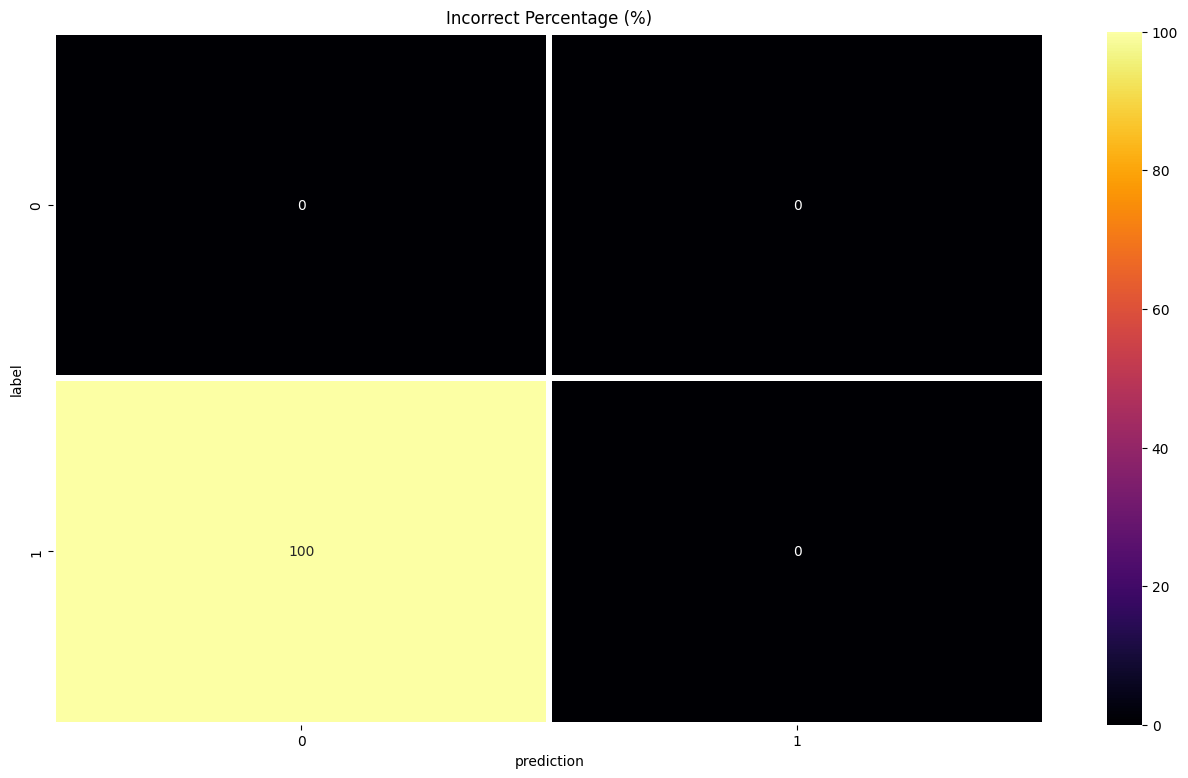

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# display
plt.figure(figsize=(16,9))
sns.heatmap(df_heatmap,annot=True,fmt='g',cmap='inferno',vmax=100,linewidths=4)
plt.title('Incorrect Percentage (%)')
plt.savefig(os.path.join(model_evaluation_dir, "confusion_matrix_{}.jpg").format(evaluation_target))
plt.show()